In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from pytz import timezone, utc
from timezonefinder import TimezoneFinder
import geopy.distance
import matplotlib.pyplot as plt
import math

plt.rcParams['font.size'] = '20'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)


# AIR TRAVEL (2015-)

In [2]:
ROOT_DIR = '/Users/alexanderguo/Desktop/picrazy2.github.io/flightlog/'
df = pd.read_csv(ROOT_DIR + 'flightlog.csv')
airports = pd.read_csv(ROOT_DIR + 'airports.csv')

tf = TimezoneFinder()

def get_offset(t, lat, lng):
    """
    returns a location's time zone offset from UTC in hours.
    """
    tz_target = timezone(tf.certain_timezone_at(lng=lng, lat=lat))
    today_target = tz_target.localize(t)
    today_utc = utc.localize(t)
    return (today_utc - today_target).total_seconds() / 3600

# Main processing

In [3]:
# Merge with airports CSV
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], 
              left_on='Dep Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 
                                             'Lat': 'Dep Lat', 
                                             'Long': 'Dep Long', 
                                             'City': 'Dep City', 
                                             'Country': 'Dep Country'})
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], 
              left_on='Arr Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 
                                             'Lat': 'Arr Lat', 
                                             'Long': 'Arr Long', 
                                             'City': 'Arr City', 
                                             'Country': 'Arr Country'})

In [4]:
# Date cleaning


DATETIME_COLS = ['Scheduled Dep Time (Local)', 
                 'Scheduled Arr Time (Local)', 
                 'Actual Dep Time (Local)', 
                 'Actual Arr Time (Local)']
important_cols = ['Date', 
                  'Scheduled Dep Time (Local)', 
                  'Scheduled Arr Time (Local)', 
                  'Actual Duration', 
                  'Airline', 
                  'Flight', 
                  'Dep Airport', 
                  'Arr Airport', 
                  'Distance', 
                  'Dep Delay (min)', 
                  'Dep Delay (min)', 
                  'Class', 
                  'Aircraft', 
                  'Registration']



df['Date'] = pd.to_datetime(df['Date'])

# Convert times to datetime object with offset from (+1) if needed.
# Note: minus not supported.
for col in DATETIME_COLS:
    for i, r in df.iterrows():
        time = str(r[col])
        if not pd.isna(r[col]):
            datetime_str = r['Date'].strftime('%Y-%m-%d') + ' ' + time.split('+')[0]
            days_offset = 0 if '+' not in time else int(time.split('+')[1])
            df.loc[i, col] = pd.to_datetime(datetime_str) + pd.Timedelta(days=days_offset)
    df[col] = pd.to_datetime(df[col])
# Set actual for future flights.
df['Actual Dep Time (Local)'] = df['Actual Dep Time (Local)'].fillna(df['Scheduled Dep Time (Local)'])
df['Actual Arr Time (Local)'] = df['Actual Arr Time (Local)'].fillna(df['Scheduled Arr Time (Local)'])


# Get departure and arrival time zones.
df['Dep Timezone'] = df[['Dep Lat', 'Dep Long']].apply(
    lambda r: timezone(tf.certain_timezone_at(lng=r['Dep Long'], lat=r['Dep Lat'])), axis=1)
df['Arr Timezone'] = df[['Arr Lat', 'Arr Long']].apply(
    lambda r: timezone(tf.certain_timezone_at(lng=r['Arr Long'], lat=r['Arr Lat'])), axis=1)

# Calculate times in UTC.
# Known error for Jordan (appears time zone is equivalent to Cairo tome)
for col in DATETIME_COLS:
    utc_col = col.split('(')[0] + '(UTC)'
    dep_or_arr = 'Dep' if 'Dep' in col else 'Arr'
    for i, r in df.iterrows():
        hours_offset = get_offset(datetime.datetime.strptime(
            r[col].strftime("%m/%d/%Y, %H:%M:%S"), "%m/%d/%Y, %H:%M:%S"), 
                                  r[dep_or_arr + ' Lat'], r[dep_or_arr + ' Long']);
        df.loc[i, utc_col] = r[col] - timedelta(hours=hours_offset)
    

# Calculate actual durations
for col in ['Scheduled Duration', 'Actual Duration']:
    df[col] = df[col.split(' ')[0] + ' Arr Time (UTC)'] - df[col.split(' ')[0] + ' Dep Time (UTC)']
    df[col + ' (min)'] = df[col].dt.total_seconds() / 60
    
# Do duration checking.
for i, r in df.iterrows():
    if r['Actual Duration (min)'] < 0 or r['Actual Duration (min)'] > 1440 or r['Scheduled Duration (min)'] < 0 or r['Scheduled Duration (min)'] > 1440:
        print('Please check this row, the duration is wrong', r)
        raise ValueError('Duration error')

In [5]:
# Add some extra columns

df['Distance'] = df.apply(lambda row: geopy.distance.distance((row['Dep Lat'], row['Dep Long']), (row['Arr Lat'], row['Arr Long'])).miles, axis=1).round().astype(int)
df['Dep Delay'] = df['Actual Dep Time (UTC)'] - df['Scheduled Dep Time (UTC)']
df['Arr Delay'] = df['Actual Arr Time (UTC)'] - df['Scheduled Arr Time (UTC)']
for i, r in df.iterrows():
    df.loc[i, 'Dep Delay (min)'] = r['Dep Delay'].seconds//60 if r['Dep Delay'].days >= 0 else r['Dep Delay'].seconds//60-1440
    df.loc[i, 'Arr Delay (min)'] = r['Arr Delay'].seconds//60 if r['Arr Delay'].days >= 0 else r['Arr Delay'].seconds//60-1440
    df.loc[i, 'Domestic/International'] = 'International' if r['Dep Country'] != r['Arr Country'] else 'Domestic'
    if i > 0:
        df.loc[i, 'Last flight arrival (UTC)'] = df.loc[i-1, 'Actual Arr Time (UTC)']
        df.loc[i, 'Time since last flight'] = r['Actual Dep Time (UTC)'] - df.loc[i, 'Last flight arrival (UTC)']

df['Minutes Made Up'] = df['Dep Delay (min)'] - df['Arr Delay (min)']

current_datetime_utc = pd.Timestamp.utcnow().tz_convert('UTC')
past_df = df[df['Scheduled Arr Time (UTC)'].dt.tz_localize('UTC') <= current_datetime_utc]
future_df = df[df['Scheduled Arr Time (UTC)'].dt.tz_localize('UTC') > current_datetime_utc]
past_df

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Dep Time (Local),Actual Arr Time (Local),Airline,Flight,Dep Airport,Arr Airport,Class,Aircraft,Registration,Arr Connect,Unnamed: 13,Dep Name,Dep City,Dep Country,Dep Lat,Dep Long,Arr Name,Arr City,Arr Country,Arr Lat,Arr Long,Dep Timezone,Arr Timezone,Scheduled Dep Time (UTC),Scheduled Arr Time (UTC),Actual Dep Time (UTC),Actual Arr Time (UTC),Scheduled Duration,Scheduled Duration (min),Actual Duration,Actual Duration (min),Distance,Dep Delay,Arr Delay,Dep Delay (min),Arr Delay (min),Domestic/International,Last flight arrival (UTC),Time since last flight,Minutes Made Up
0,2015-01-03,2015-01-03 13:45:00,2015-01-03 14:10:00,2015-01-03 13:55:00,2015-01-03 14:29:00,Hainan,HU481,PEK,BOS,Economy,NaN,NaN,NaN,NaN,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,Asia/Shanghai,America/New_York,2015-01-03 05:45:00,2015-01-03 19:10:00,2015-01-03 05:55:00,2015-01-03 19:29:00,0 days 13:25:00,805.0,0 days 13:34:00,814.0,6737,0 days 00:10:00,0 days 00:19:00,10.0,19.0,International,NaT,NaT,-9.0
1,2015-03-08,2015-03-08 08:34:00,2015-03-08 10:01:00,2015-03-08 08:52:00,2015-03-08 09:42:00,United,UA1711,BOS,EWR,Recliner First,B738,N54241,1.0,NaN,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,America/New_York,America/New_York,2015-03-08 12:34:00,2015-03-08 14:01:00,2015-03-08 12:52:00,2015-03-08 13:42:00,0 days 01:27:00,87.0,0 days 00:50:00,50.0,201,0 days 00:18:00,-1 days +23:41:00,18.0,-19.0,Domestic,2015-01-03 19:29:00,63 days 17:23:00,37.0
2,2015-03-08,2015-03-08 12:55:00,2015-03-09 15:00:00,2015-03-08 13:40:00,2015-03-09 15:10:00,United,UA89,EWR,PEK,Economy,B772,N78005,NaN,NaN,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,America/New_York,Asia/Shanghai,2015-03-08 16:55:00,2015-03-09 07:00:00,2015-03-08 17:40:00,2015-03-09 07:10:00,0 days 14:05:00,845.0,0 days 13:30:00,810.0,6831,0 days 00:45:00,0 days 00:10:00,45.0,10.0,International,2015-03-08 13:42:00,0 days 03:58:00,35.0
3,2015-03-19,2015-03-19 17:00:00,2015-03-19 18:45:00,2015-03-19 17:24:00,2015-03-19 18:15:00,United,UA88,PEK,EWR,Economy,B772,N78005,1.0,NaN,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,Asia/Shanghai,America/New_York,2015-03-19 09:00:00,2015-03-19 22:45:00,2015-03-19 09:24:00,2015-03-19 22:15:00,0 days 13:45:00,825.0,0 days 12:51:00,771.0,6831,0 days 00:24:00,-1 days +23:30:00,24.0,-30.0,International,2015-03-09 07:10:00,10 days 02:14:00,54.0
4,2015-03-19,2015-03-19 20:32:00,2015-03-19 21:46:00,2015-03-19 21:21:00,2015-03-19 22:03:00,United,UA1409,EWR,BOS,Economy,B734,N87512,NaN,NaN,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,America/New_York,America/New_York,2015-03-20 00:32:00,2015-03-20 01:46:00,2015-03-20 01:21:00,2015-03-20 02:03:00,0 days 01:14:00,74.0,0 days 00:42:00,42.0,201,0 days 00:49:00,0 days 00:17:00,49.0,17.0,Domestic,2015-03-19 22:15:00,0 days 03:06:00,32.0
5,2015-07-05,2015-07-05 17:27:00,2015-07-05 20:45:00,2015-07-05 18:00:00,2015-07-05 20:30:00,JetBlue,B6487,BOS,LAX,Economy,A320,N775JB,NaN,NaN,General Edward Lawrence Logan International Ai...,Boston,United States,42.364300,-71.005203,Los Angeles International Airport,Los Angeles,United States,33.942501,-118.407997,America/New_York,America/Los_Angeles,2015-07-05 21:27:00,2015-07-06 03:45:00,2015-07-05 22:00:00,2015-07-06 03:30:00,0 days 06:18:00,378.0,0 days 05:30:00,330.0,2611,0 days 00:33:00,-1 days +23:45:00,33.0,-15.0,Domestic,2015-03-20 02:03:00,107 days 19:57:00,48

In [6]:
# Calculate totals

TOTAL_DIST = df['Distance'].sum()
TOTAL_TIME = df['Actual Duration (min)'].sum()
NUM_FLIGHTS = df['Date'].count()
NUM_PAST_FLIGHTS = past_df['Date'].count()
NUM_FUTURE_FLIGHTS = future_df['Date'].count()
NUM_AIRLINES = df['Airline'].nunique()
NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))
sorted_by_flight_interval = df.sort_values('Time since last flight', ascending=False).reset_index()
LONGEST_INTERVAL = str(sorted_by_flight_interval.loc[0, 'Time since last flight'])
LONGEST_INTERVAL_0 = str(sorted_by_flight_interval.loc[0, 'Last flight arrival (UTC)'].date())
LONGEST_INTERVAL_1 = str(sorted_by_flight_interval.loc[0, 'Scheduled Dep Time (UTC)'].date())
sorted_by_flight_interval_reverse = df.sort_values('Time since last flight', ascending=True).reset_index()
SHORTEST_INTERVAL = str(sorted_by_flight_interval_reverse.loc[0, 'Time since last flight'])
SHORTEST_INTERVAL_0 = str(sorted_by_flight_interval_reverse.loc[0, 'Last flight arrival (UTC)'].date())
SHORTEST_INTERVAL_1 = str(sorted_by_flight_interval_reverse.loc[0, 'Scheduled Dep Time (UTC)'].date())


print('Total Distance Flown (miles): ' + str(TOTAL_DIST))
print('Total time in the air: ' + str(timedelta(minutes=int(TOTAL_TIME))))
print('Total Flights: ' + str(NUM_FLIGHTS))
print('Number of Airlines: ' + str(NUM_AIRLINES))
print('Number of Countries: ' + str(NUM_COUNTRIES))
print('Number of Airports: ' + str(NUM_AIRPORTS))
print('Longest time without flying: ' + LONGEST_INTERVAL + ', ' + LONGEST_INTERVAL_0 + ' to ' + LONGEST_INTERVAL_1)
# print('Shortest time without flying: ' + SHORTEST_INTERVAL + ', ' + SHORTEST_INTERVAL_0 + ' to ' + SHORTEST_INTERVAL_1)


df.to_csv('full_df.csv')


Total Distance Flown (miles): 681506
Total time in the air: 58 days, 10:42:00
Total Flights: 305
Number of Airlines: 47
Number of Countries: 38
Number of Airports: 107
Longest time without flying: 157 days 18:22:00, 2016-07-10 to 2016-12-15


# FLIGHTS SORTED BY DISTANCE

,Dep Airport,Arr Airport,Dep Country,Arr Country,Distance_x,Date_y,Distance_y
0,SFO,SIN,United States,Singapore,8446,3,25338
1,EWR,CPT,United States,South Africa,7817,1,7817
2,SYD,LAX,Australia,United States,7488,1,7488
3,BOS,PVG,United States,China,7308,2,14616
4,SFO,HKG,United States,Hong Kong,6927,1,6927
5,PEK,IAD,China,United States,6921,3,20763
6,DXB,YYZ,United Arab Emirates,Canada,6899,1,6899
7,PEK,EWR,China,United States,6831,15,102465
8,PEK,BOS,China,United States,6737,4,26948
9,EWR,NRT,United States,Japan,6732,1,6732


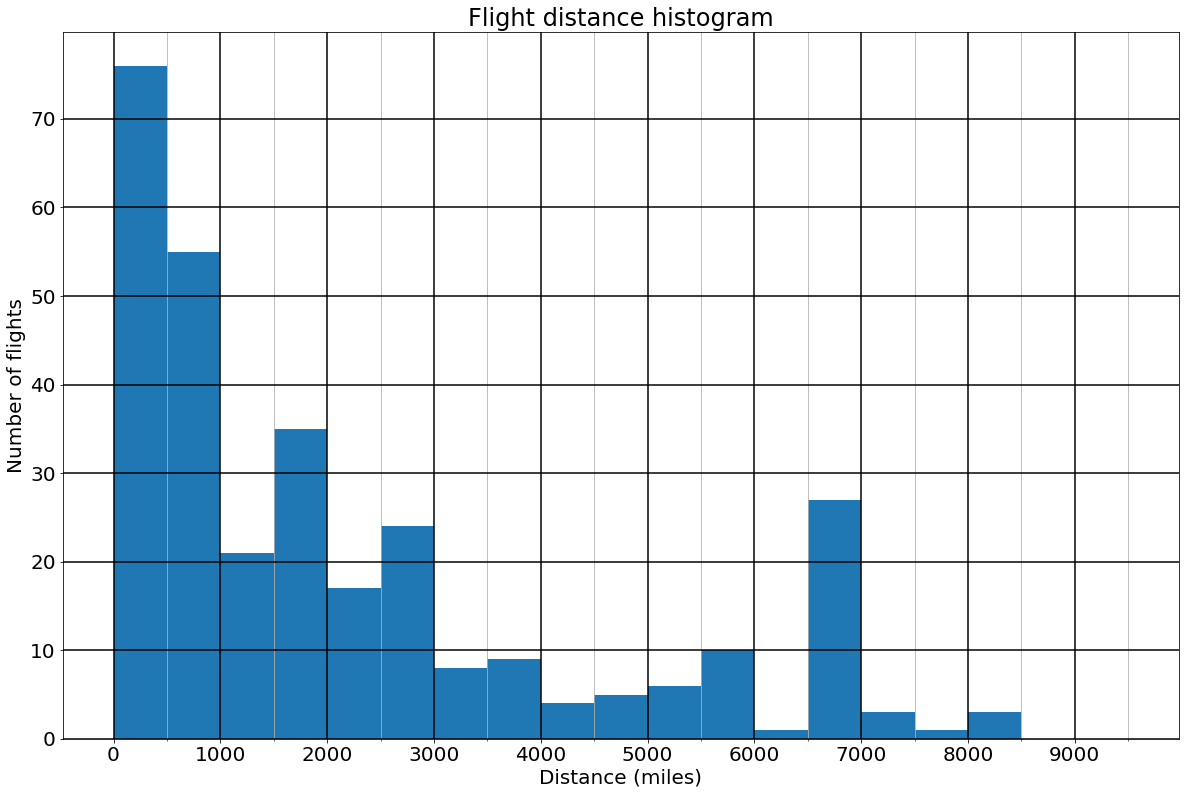

In [7]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
route_distance_cols = ['Dep Airport', 'Arr Airport', 'Dep Country', 'Arr Country', 'Distance_x', 'Date_y', 'Distance_y']

fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, 10000, 500))
ax.hist(df['Distance'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight distance histogram')
plt.savefig('figures/distance_hist.jpg', bbox_inches='tight')

longest_flights = df.sort_values(['Distance'], ascending=False).drop_duplicates(subset='Distance').head(20)
longest_flights = longest_flights.merge(routes_sorted, on='Sorted Route')
longest_flights.reset_index()[route_distance_cols]
                                                                                        


In [8]:
# Shortest flights
shortest_flights = df.sort_values(['Distance'], ascending=True).drop_duplicates(subset='Distance').head(20)
shortest_flights = shortest_flights.merge(routes_sorted, on='Sorted Route')
shortest_flights.reset_index()[route_distance_cols]
                                                     

,Dep Airport,Arr Airport,Dep Country,Arr Country,Distance_x,Date_y,Distance_y
0,PHL,JFK,United States,United States,94,1,94
1,HNL,LIH,United States,United States,102,1,102
2,IAD,PHL,United States,United States,135,1,135
3,IAH,AUS,United States,United States,140,1,140
4,KUL,SIN,Malaysia,Singapore,185,1,185
5,JFK,BOS,United States,United States,187,1,187
6,LJG,KMG,China,China,199,1,199
7,BOS,EWR,United States,United States,201,26,5226
8,LHR,CDG,United Kingdom,France,216,1,216
9,LAX,LAS,United States,United States,236,1,236


In [9]:
# Longest domestic
longest_domestic = df[df['Domestic/International']=='Domestic'].sort_values('Distance', ascending=False).drop_duplicates(subset='Distance').head(30)
longest_domestic = longest_domestic.merge(routes_sorted, on='Sorted Route')
longest_domestic.reset_index()[route_distance_cols]


,Dep Airport,Arr Airport,Dep Country,Arr Country,Distance_x,Date_y,Distance_y
0,OGG,EWR,United States,United States,4903,1,4903
1,ORD,HNL,United States,United States,4244,1,4244
2,HNL,IAH,United States,United States,3904,1,3904
3,DEN,OGG,United States,United States,3302,1,3302
4,BOS,SFO,United States,United States,2704,8,21632
5,LAX,BOS,United States,United States,2611,3,7833
6,SFO,JFK,United States,United States,2586,2,5172
7,EWR,SFO,United States,United States,2565,6,15390
8,PHL,SFO,United States,United States,2521,2,5042
9,LAX,EWR,United States,United States,2454,1,2454


In [10]:
# Shortest international
shortest_international = df[df['Domestic/International']=='International'].sort_values('Distance', ascending=True).drop_duplicates(subset='Distance').head(20)
shortest_international = shortest_international.merge(routes_sorted, on='Sorted Route')
shortest_international.reset_index()[route_distance_cols]


,Dep Airport,Arr Airport,Dep Country,Arr Country,Distance_x,Date_y,Distance_y
0,KUL,SIN,Malaysia,Singapore,185,1,185
1,LHR,CDG,United Kingdom,France,216,1,216
2,AMM,PFO,Jordan,Cyprus,290,1,290
3,CAI,AMM,Egypt,Jordan,294,1,294
4,LIS,MAD,Portugal,Spain,319,1,319
5,PRG,WAW,Czech Republic,Poland,325,1,325
6,LHR,FRA,United Kingdom,Germany,408,1,408
7,KIX,ICN,Japan,South Korea,535,1,535
8,ICN,PEK,South Korea,China,562,2,1124
9,GMP,PEK,South Korea,China,577,2,1154


# FLIGHTS SORTED BY DURATION

,Date,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Distance,Dep Delay (min),Dep Delay (min),Class,Aircraft,Registration
218,2022-11-10,2022-11-10 10:40:00,2022-11-11 20:15:00,0 days 16:09:00,United,UA29,SFO,SIN,8446,50.0,50.0,Economy,B789,N28987
221,2022-11-28,2022-11-28 10:15:00,2022-11-28 08:50:00,0 days 14:33:00,United,UA2,SIN,SFO,8446,13.0,13.0,Economy,B789,N29985
72,2018-01-07,2018-01-07 10:00:00,2018-01-07 08:40:00,0 days 14:09:00,United,UA2,SIN,SFO,8446,20.0,20.0,Lie-flat Business,B789,N38955
74,2018-03-22,2018-03-22 16:35:00,2018-03-23 19:20:00,0 days 14:03:00,Hainan,HU7962,BOS,PVG,7308,14.0,14.0,Economy,B788,B2750
75,2018-03-29,2018-03-29 12:25:00,2018-03-29 14:35:00,0 days 14:03:00,Hainan,HU7961,PVG,BOS,7308,26.0,26.0,Economy,B789,B7835
98,2019-01-06,2019-01-06 23:55:00,2019-01-07 05:05:00,0 days 13:50:00,Air Canada,AC57,DXB,YYZ,6899,74.0,74.0,Lie-flat Business,B77W,CFRAM
260,2023-09-30,2023-09-30 23:20:00,2023-10-02 05:00:00,0 days 13:35:00,United,UA877,SFO,HKG,6927,34.0,34.0,Economy,B77W,N2747U
0,2015-01-03,2015-01-03 13:45:00,2015-01-03 14:10:00,0 days 13:34:00,Hainan,HU481,PEK,BOS,6737,10.0,10.0,Economy,NaN,NaN
126,2019-12-18,2019-12-18 20:30:00,2019-12-19 18:00:00,0 days 13:33:00,United,UA1122,EWR,CPT,7817,134.0,134.0,Lie-flat Business,B789,N27957
2,2015-03-08,2015-03-08 12:55:00,2015-03-09 15:00:00,0 days 13:30:00,United,UA89,EWR,PEK,6831,45.0,45.0,Economy,B772,N78005


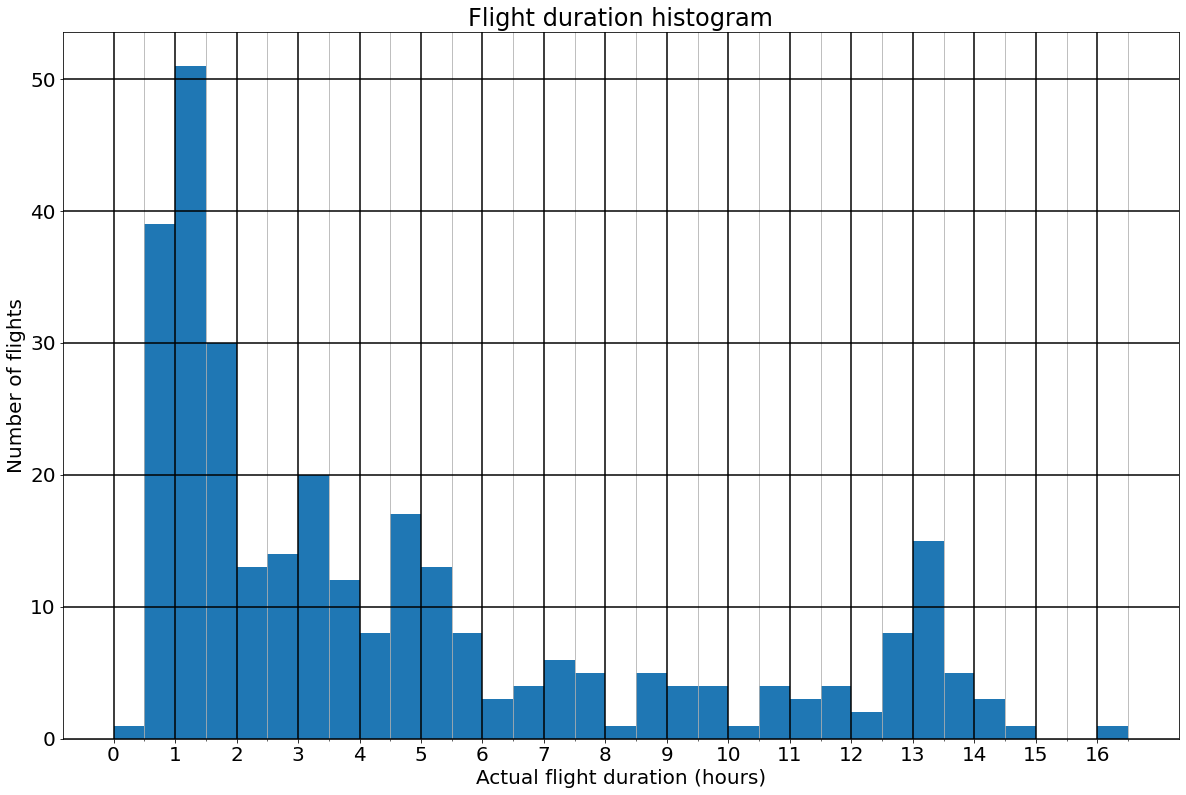

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20,13))
bins = list(range(0, math.ceil(df['Actual Duration (min)'].max()/30)*30+30, 30))
ax.hist(df['Actual Duration (min)'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if i%2 == 0])
ax.set_xticklabels([b//60 for i, b in enumerate(bins) if i%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Actual flight duration (hours)')
ax.set_ylabel('Number of flights')
ax.set_title('Flight duration histogram')
plt.savefig('figures/duration_hist.jpg', bbox_inches='tight')

df.sort_values(['Actual Duration (min)'], ascending=False).head(40)[important_cols]

# ALL COUNTRIES AND AIRPORTS

In [12]:
dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
dep_countries.columns = ['Country', 'Airport', 'Departures']
arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
arr_countries.columns = ['Country', 'Airport', 'Arrivals']
connect_countries = df[df['Arr Connect'] == 1].groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
connect_countries.columns = ['Country', 'Airport', 'Connections']
countries = pd.merge(pd.merge(dep_countries, arr_countries, how='outer'), connect_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first', 'Connections': 'first'})
countries['Total Visits'] = countries['Departures'] + countries['Arrivals'] - countries['Connections']
countries['Departures'] = countries['Departures'] - countries['Connections']
countries['Arrivals'] = countries['Arrivals'] - countries['Connections']
countries.astype('int32')

Departures  Arrivals  Connections  Total Visits
Country               Airport                                                 
Australia             BNE               1         1            0             2
                      SYD               1         1            0             2
Bahamas               NAS               1         1            0             2
Bermuda               BDA               1         1            0             2
Canada                YYC               1         1            0             2
                      YYZ               0         0            1             1
China                 CGQ               1         0            0             1
                      CKG               0         1            0             1
                      CTU               1         1            0             2
                      DNH               1         1            0             2
                      HGH               1         1            0             2
                      HRB               1         1            0             2
                      KJI               2         2            0             4
                      KMG               0         0            1             1
                      KWL               1         1            0             2
                      LHW               0         1            1             2
                      LJG               1         1            0             2
                      PEK              34        33            1            68
                      PKX               2         2            0             4
                      PVG               2         3            0             5
                      SHA               2         0            0             2
                      SYX               2         2            0             4
                      SZX               1         1            0             2
                      URC               2         2            2             6
                      WUX               1         1            0             2
                      XIY               0         0            1             1
                      XMN               1         1            0             2
                      XNN               1         0            0             1
                      YNJ               0         1            0             1
Costa Rica            SJO               1         1            0             2
Cyprus                PFO               0         0            1             1
Czech Republic        PRG               1         1            0             2
Dominican Republic    PUJ               1         1            0             2
Egypt                 CAI               0         0            1             1
France                CDG               2         3            0             5
                      NCE               1         1            0             2
Germany               FRA               1         1            2             4
                      MUC               0         0            3             3
Hong Kong             HKG               2         2            0             4
Iceland               KEF               1         1            0             2
Italy                 FCO               1         1            0             2
Japan                 HND               1         0            0             1
                      KIX               1         1            1             3
                      NRT               0         1            1             2
Jordan                AMM               1         1            0             2
Malaysia              KUL               1         1            0             2
Mexico                MEX               1         1            0             2
                      PVR               1         1            0             2
Mongolia              UBN               1         1            0             2
Ne

# AIRPORTS SORTED BY TOTAL VISITS

In [13]:
countries_sorted = countries.sort_values(by=['Total Visits'], ascending=False)
countries_sorted = countries_sorted.astype('int32')
countries_sorted.head(20)

Departures  Arrivals  Connections  Total Visits
Country        Airport                                                 
United States  BOS              37        37            0            74
China          PEK              34        33            1            68
United States  SFO              30        30            4            64
               EWR               9         9           23            41
               LAX               4         4            2            10
United Kingdom LHR               4         5            1            10
United States  DEN               1         1            6             8
               PHL               4         4            0             8
Singapore      SIN               3         3            1             7
United States  ORD               2         2            3             7
               IAD               0         0            7             7
China          URC               2         2            2             6
Portugal       LIS               1         1            4             6
United States  LAS               3         2            0             5
               JFK               1         2            2             5
China          PVG               2         3            0             5
France         CDG               2         3            0             5
United States  HNL               2         2            1             5
               IAH               0         0            5             5
China          PKX               2         2            0             4

,Total Visits,Airport
Country,,
United States,281,30
China,119,23
United Kingdom,13,3
Singapore,7,1
France,7,2
Germany,7,2
Portugal,6,1
Japan,6,3
New Zealand,6,3


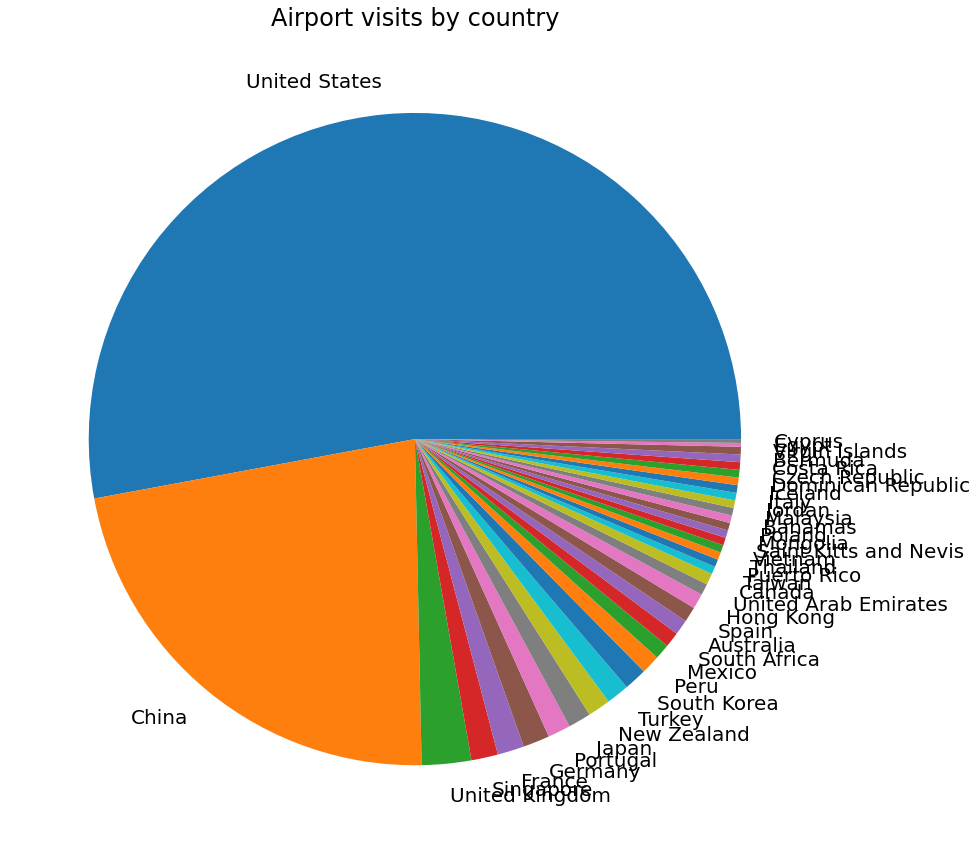

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
airports_by_country = countries_sorted.reset_index().groupby('Country').agg({'Total Visits': sum, 'Airport': 'count'}).sort_values(by='Total Visits', ascending=False)
airports_by_country.plot('Country', 'Total Visits', kind='pie', legend=False, ax=ax)
ax.set_title('Airport visits by country')
ax.set_ylabel('')
plt.savefig('figures/countries.jpg', bbox_inches='tight')

airports_by_country

In [15]:
# Destinations by airport


# TOP ROUTES

In [16]:
routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes.columns = ['Count', 'Total Distance']
routes.head(10)

Count  Total Distance
Dep Airport Arr Airport                       
BOS         EWR             14            2814
EWR         BOS             12            2412
            PEK             10           68310
SFO         BOS              6           16224
PEK         EWR              5           34155
            SFO              3           17739
SFO         EWR              3            7695
IAD         BOS              3            1239
EWR         SFO              3            7695
BOS         ORD              3            2601

In [17]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes_sorted.columns = ['Count', 'Total Distance']
routes_sorted[routes_sorted['Count'] >=2].reset_index()

,Sorted Route,Count,Total Distance
0,BOS EWR,26,5226
1,EWR PEK,15,102465
2,BOS SFO,8,21632
3,BOS IAD,6,2478
4,EWR SFO,6,15390
5,BOS DEN,4,7016
6,PEK SYX,4,6240
7,KJI URC,4,1196
8,BOS ORD,4,3468
9,BOS PEK,4,26948


# TOP AIRLINES

In [18]:
airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
airlines.columns = ['Count', 'Total Distance', 'Actual Duration (min)']
airlines

,Count,Total Distance,Actual Duration (min)
Airline,,,
United,157,423727,50599.0
Air China,17,22430,3401.0
Hainan,14,50973,6244.0
China Southern,11,8980,1261.0
Lufthansa,10,30640,3533.0
JetBlue,9,14963,1846.0
Delta,8,4032,608.0
TAP,8,21505,2664.0
American,5,4662,652.0


In [19]:
# fig, ax = plt.subplots(1, 2, figsize=(20,10))
# airlines.plot('Airline', 'Count', kind='pie', legend=False, ax=ax[0])
# airlines.sort_values(by='Actual Duration (min)', ascending=False).plot('Airline', 'Actual Duration (min)', kind='pie', legend=False, ax=ax[1])
# ax[0].set_title('Flights by airline')
# ax[1].set_title('Total travel duration by airline')
# ax[0].set_ylabel('')
# ax[1].set_ylabel('')
# plt.savefig('figures/airlines.jpg', bbox_inches='tight')


# TOP AIRCRAFT

In [20]:
aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
aircraft.columns = ['Count', 'Total Distance', 'Actual Duration (min)']
aircraft

,Count,Total Distance,Actual Duration (min)
Aircraft,,,
B738,43,50272,6904.0
A320,31,23968,3371.0
B772,30,165145,18935.0
B789,19,95168,10681.0
A321,17,22110,2908.0
B739,17,12531,1801.0
A319,14,10963,1589.0
B737,11,7246,1190.0
B77W,11,44831,5352.0


In [21]:
# fig, ax = plt.subplots(1, 2, figsize=(20,10))
# aircraft.plot('Aircraft', 'Count', kind='pie', legend=False, ax=ax[0])
# aircraft.sort_values(by='Actual Duration (min)', ascending=False).plot('Aircraft', 'Actual Duration (min)', kind='pie', legend=False, ax=ax[1])
# ax[0].set_title('Flights by aircraft type')
# ax[1].set_title('Total travel time by aircraft type')
# ax[0].set_ylabel('')
# ax[1].set_ylabel('')
# plt.savefig('figures/aircrafts.jpg', bbox_inches='tight')


# TOP AIRCRAFT REGS

In [22]:
reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(15)
reg.columns = ['Count', 'Total Distance']
reg

,,Count,Total Distance
Registration,Aircraft,,
N78005,B772,3,20493
N76010,B772,3,20178
N69020,B772,2,9250
N37018,B772,2,12489
N458UA,A320,2,847
N78008,B772,2,13662
N19136,B752,2,5408
B2750,B788,2,14045
B7880,B789,2,1364


# TRAVEL BY YEAR

In [23]:
dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Actual Duration (min)': sum, 'Date': 'count'})
dist_year.columns = ['Distance', 'Actual Duration (min)', 'Flights']
missing_years = set(range(dist_year.index.min(), dist_year.index.max())) - set(dist_year.index)
for yr in missing_years:
    dist_year = dist_year.append(pd.DataFrame({'Distance': 0, 'Actual Duration (min)': 0, 'Flights': 0}, index=[yr]))
dist_year

,Distance,Actual Duration (min),Flights
Date,,,
2015,36175,4426.0,11
2016,58573,7009.0,22
2017,78052,9500.0,39
2018,77926,9282.0,26
2019,84246,10087.0,32
2020,48041,6064.0,30
2021,58953,7404.0,33
2022,88374,10323.0,35
2023,84550,10962.0,44


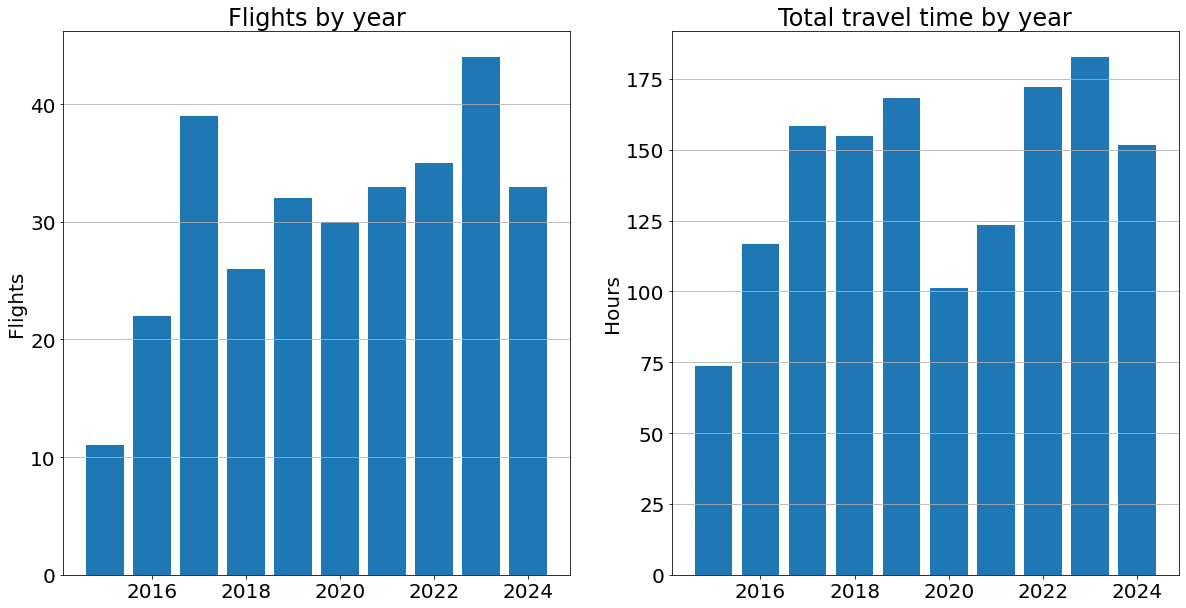

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].bar(dist_year.index, dist_year['Flights'])
ax[0].grid(axis='y')
ax[0].set_title('Flights by year')
ax[0].set_ylabel('Flights')
ax[1].bar(dist_year.index, dist_year['Actual Duration (min)']/60)
ax[1].grid(axis='y')
ax[1].set_title('Total travel time by year')
ax[1].set_ylabel('Hours')
plt.savefig('figures/by_year.jpg', bbox_inches='tight')


# TRAVEL BY MONTH

In [25]:
df['Month'] = df['Date']
dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Actual Duration (min)': sum, 'Date': 'count'})
dist_yearm.columns = ['Distance', 'Actual Duration (min)', 'Flights']

dist_yearm.sort_values(by='Distance', ascending=False).head(30)

Distance  Actual Duration (min)  Flights
Date Month                                          
2019 12        20872                 2402.0        7
2024 1         20637                 2830.0        8
2021 6         18559                 2312.0       10
2024 4         18505                 2442.0        7
2022 11        18244                 2032.0        4
2023 3         18179                 2233.0        7
     9         17879                 2069.0        4
2022 2         17772                 2054.0        6
2016 3         17482                 2157.0        8
2018 3         17029                 1969.0        3
2022 12        16797                 1912.0        6
2019 8         15448                 1750.0        3
2022 10        15008                 1770.0        6
2020 1         14596                 1781.0        8
2021 11        14546                 1795.0        6
2017 10        14366                 1696.0        4
2016 12        14233                 1762.0        6
2018 10        14064                 1668.0        4
2015 3         14064                 1673.0        4
2017 3         14064                 1610.0        4
2023 12        13636                 1983.0        7
2016 7         12787                 1462.0        5
2018 12        11673                 1550.0        3
2024 6         11657                 1530.0        5
2018 1         11150                 1152.0        2
2015 12        10152                 1320.0        4
2017 1         10099                 1067.0        2
2021 5          9975                 1252.0        7
2024 7          9884                 1354.0        6
2017 12         9812                 1185.0        3

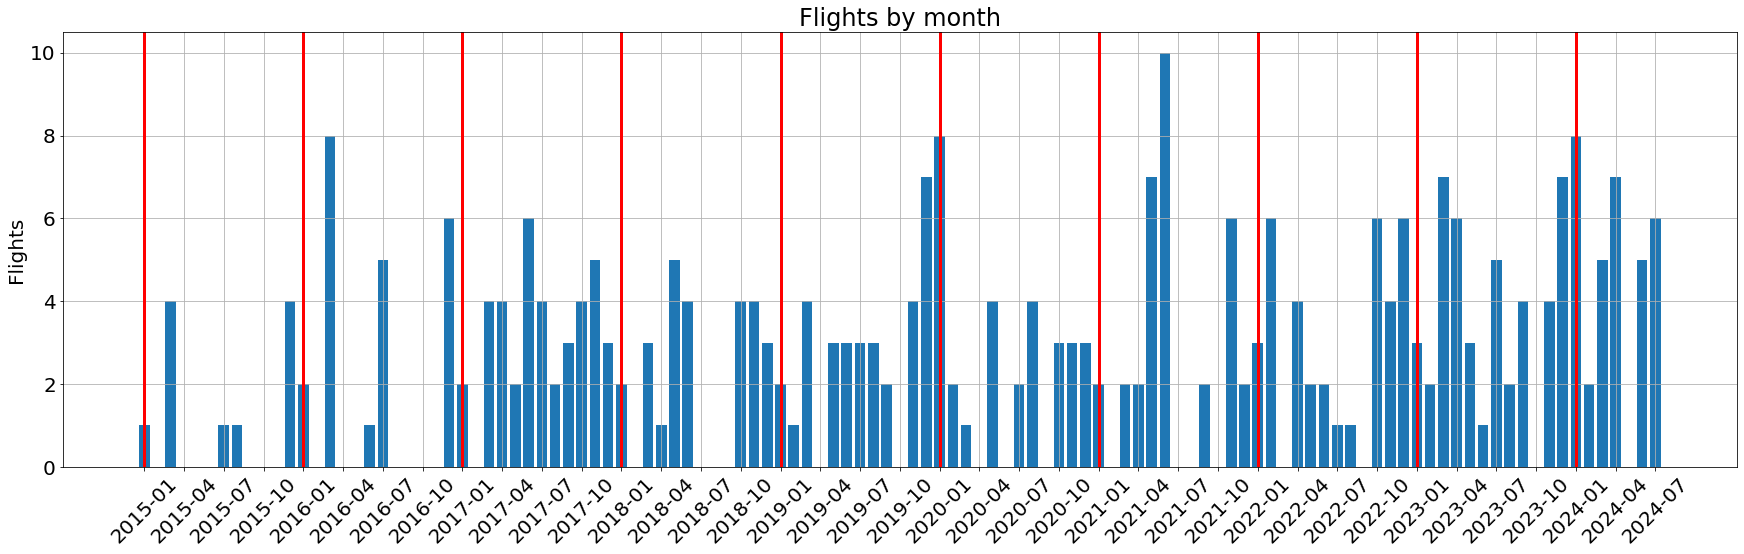

In [26]:
months = df['Month'].sort_values()
start_month = months.iloc[0]
end_month = months.iloc[-1]

index = pd.period_range(start_month, end_month, freq='M')
index_str = pd.DataFrame(index.astype(str), columns=['Y-M'])
# dist_yearm.reindex(index)

a = dist_yearm.reset_index()
a['Date'] = a['Date'].astype('int32').astype(str)
a['Month'] = a['Month'].astype('str').str.zfill(2)

a['Y-M'] = a['Date'] + '-' + a['Month']
a = a.merge(index_str, how='outer').sort_values(['Y-M']).fillna(0)

fig, ax = plt.subplots(figsize=(30,8))
ax.bar(a['Y-M'], a['Flights'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Flights')
ax.set_title('Flights by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/flights_by_month.jpg', bbox_inches='tight')


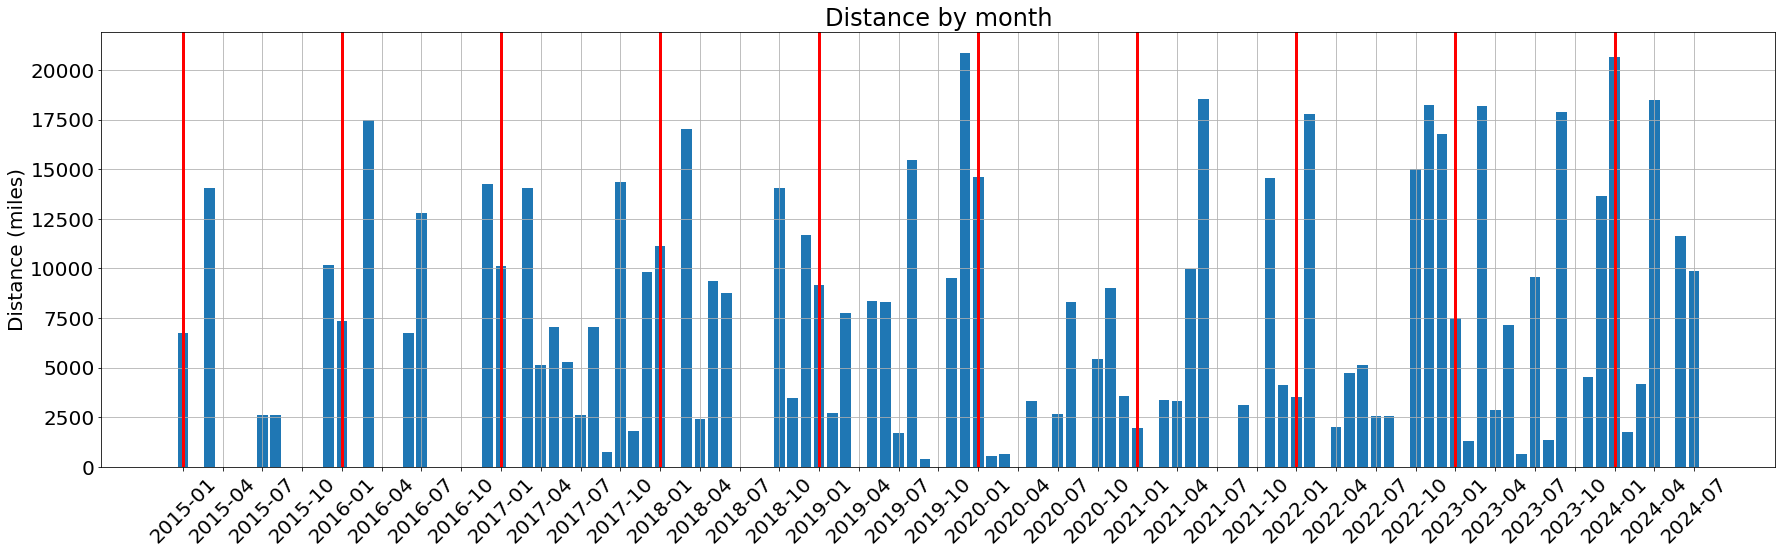

In [27]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(a['Y-M'], a['Distance'], linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Distance (miles)')
ax.set_title('Distance by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/distance_month.jpg', bbox_inches='tight')

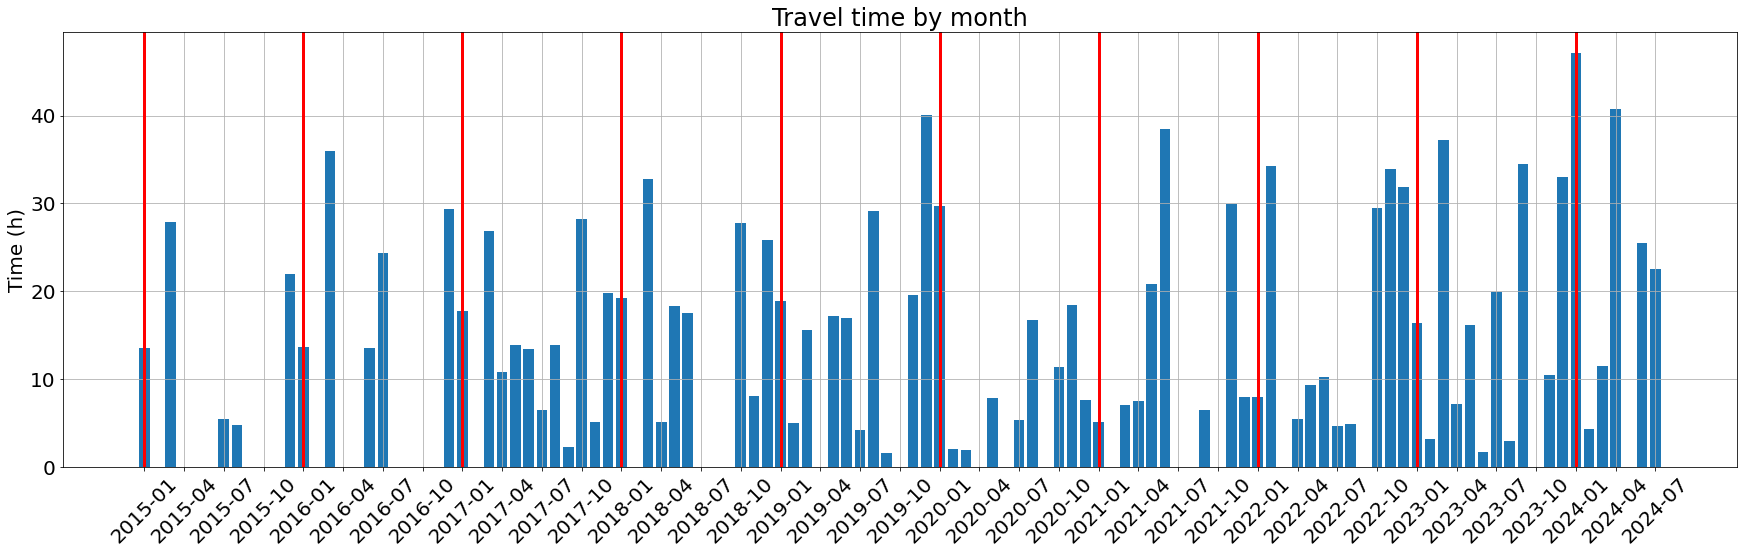

In [28]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(a['Y-M'], a['Actual Duration (min)']/60, linewidth=5)
ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)
ax.set_ylabel('Time (h)')
ax.set_title('Travel time by month')
ax.grid(True)


for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max()+1): 
    if str(year) + '-01' in a['Y-M'].tolist():
        ax.axvline(str(year) + '-01', linewidth=3, color='red')
        
plt.savefig('figures/time_month.jpg', bbox_inches='tight')

# DOMESTIC AND INTERNATIONAL BREAKDOWN

In [29]:
dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
dom_int.columns = ['Distance', 'Flights']
dom_int

,Distance,Flights
Domestic/International,,
Domestic,188724,173
International,492782,132


In [30]:
print('Domestic average dist: ' + str(dom_int.loc['Domestic', 'Distance'] / dom_int.loc['Domestic', 'Flights']))
print('International average dist: ' + str(dom_int.loc['International', 'Distance'] / dom_int.loc['International', 'Flights']))

Domestic average dist: 1090.8901734104047
International average dist: 3733.1969696969695


In [31]:
year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})
year_dom_int.columns = ['Distance', 'Flights']
year_dom_int = year_dom_int.reset_index()

# fig, ax = plt.subplots(figsize=(30,8))
# ax.bar(year_dom_int['Date'], year_dom_int['Date'], linewidth=5)
# # ticks = [x for i, x in enumerate(list(a['Y-M'])) if i % 3 == 0]
# # ax.set_xticks(ticks)
# # ax.set_xticklabels(ticks, rotation=45)
# # ax.set_ylabel('Flights')
# # ax.set_title('Flights by month')
# # ax.grid(True)

# plt.savefig('figures/domestic_international_year.jpg', bbox_inches='tight')

In [32]:
dom_int_country = df[df['Domestic/International'] == 'Domestic'].groupby('Dep Country').agg({'Distance': sum, 'Date': 'count'})
dom_int_country.columns = ['Distance', 'Flights']
dom_int_country.sort_values('Distance', ascending=False)

,Distance,Flights
Dep Country,,
United States,150490,124
China,33607,38
New Zealand,1100,2
France,864,2
Peru,728,2
Turkey,704,2
Australia,467,1
South Africa,403,1
Spain,361,1


# FARE CLASS BREAKDOWN

In [33]:
clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
clas.columns = ['Distance', 'Flights']
clas

,Distance,Flights
Class,,
Economy,471046,234
International First,5699,1
Lie-flat Business,162225,33
Premium Economy,18826,6
Recliner First,23710,31


In [34]:
year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})
year_clas.columns = ['Distance', 'Flights']
year_clas

Distance  Flights
Date Class                                 
2015 Economy                 35773        9
     Recliner First            402        2
2016 Economy                 31518       16
     Lie-flat Business       26854        5
     Recliner First            201        1
2017 Economy                 51109       32
     Lie-flat Business       23930        4
     Recliner First           3013        3
2018 Economy                 59664       19
     Lie-flat Business       14788        3
     Recliner First           3474        4
2019 Economy                 45540       23
     Lie-flat Business       38092        7
     Recliner First            614        2
2020 Economy                 27504       19
     Lie-flat Business       15315        4
     Recliner First           5222        7
2021 Economy                 34462       24
     Lie-flat Business       19675        5
     Premium Economy          2419        1
     Recliner First           2397        3
2022 Economy                 58251       22
     International First      5699        1
     Lie-flat Business        9081        2
     Premium Economy          7529        3
     Recliner First           7814        7
2023 Economy                 67078       38
     Lie-flat Business        8021        2
     Premium Economy          8878        2
     Recliner First            573        2
2024 Economy                 60147       32
     Lie-flat Business        6469        1


# CLASS AND TRIP TYPE BREAKDOWN

In [35]:
clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})
clas_dom_int.columns = ['Distance', 'Flights']
clas_dom_int

Distance  Flights
Domestic/International Class                                 
Domestic               Economy                136166      135
                       Lie-flat Business       28027        9
                       Premium Economy          9948        4
                       Recliner First          14583       25
International          Economy                334880       99
                       International First      5699        1
                       Lie-flat Business      134198       24
                       Premium Economy          8878        2
                       Recliner First           9127        6

In [36]:
# fig, ax = plt.subplots(1, 2, figsize=(20,10))
# clas_dom_int.plot('Class', 'Flights', kind='pie', legend=False, ax=ax[0])
# clas_dom_int.plot('Class', 'Distance', kind='pie', legend=False, ax=ax[1])
# ax[0].set_title('Flights by class and trip type')
# ax[1].set_title('Total distance by class and trip type')
# ax[0].set_ylabel('')
# ax[1].set_ylabel('')
# plt.savefig('figures/class_and_type.jpg', bbox_inches='tight')

# DEP, ARR TIMES, DELAYS

Early arrivals: 203 69%
On time arrivals (within 15 min): 46 16%
Late arrivals: 37 13%
Really late arrivals (1+hour): 8 3%


,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Dep Time (Local),Actual Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Dep Delay,Arr Delay
0,2020-08-28 23:45:00,2020-08-29 06:51:00,2020-08-29 04:15:00,2020-08-29 10:43:00,0 days 04:28:00,United,UA1104,ANC,DEN,0 days 04:30:00,0 days 03:52:00
1,2018-06-02 21:05:00,2018-06-02 23:20:00,2018-06-03 01:02:00,2018-06-03 03:00:00,0 days 01:58:00,Hainan,HU7178,HGH,PEK,0 days 03:57:00,0 days 03:40:00
2,2022-08-04 20:30:00,2022-08-04 23:41:00,2022-08-05 00:33:00,2022-08-05 02:29:00,0 days 04:56:00,United,UA1257,EWR,SFO,0 days 04:03:00,0 days 02:48:00
3,2017-03-11 12:00:00,2017-03-12 15:00:00,2017-03-11 15:44:00,2017-03-12 17:28:00,0 days 12:44:00,United,UA89,EWR,PEK,0 days 03:44:00,0 days 02:28:00
4,2021-06-04 15:10:00,2021-06-04 16:21:00,2021-06-04 18:00:00,2021-06-04 18:47:00,0 days 00:47:00,United,UA3433,EWR,BOS,0 days 02:50:00,0 days 02:26:00
5,2020-02-19 06:46:00,2020-02-19 08:25:00,2020-02-19 08:35:00,2020-02-19 09:51:00,0 days 01:16:00,JetBlue,B6159,BOS,PHL,0 days 01:49:00,0 days 01:26:00
6,2019-12-18 20:30:00,2019-12-19 18:00:00,2019-12-18 22:44:00,2019-12-19 19:17:00,0 days 13:33:00,United,UA1122,EWR,CPT,0 days 02:14:00,0 days 01:17:00
7,2018-04-02 15:30:00,2018-04-02 17:35:00,2018-04-02 17:31:00,2018-04-02 18:35:00,0 days 05:04:00,Wow,WW125,KEF,BOS,0 days 02:01:00,0 days 01:00:00
8,2017-06-09 08:40:00,2017-06-09 09:45:00,2017-06-09 09:38:00,2017-06-09 10:44:00,0 days 01:06:00,China Southern,CZ6613,URC,KJI,0 days 00:58:00,0 days 00:59:00
9,2022-12-11 09:20:00,2022-12-12 17:30:00,2022-12-11 11:46:00,2022-12-12 18:28:00,0 days 07:42:00,Air New Zealand,NZ9,HNL,AKL,0 days 02:26:00,0 days 00:58:00


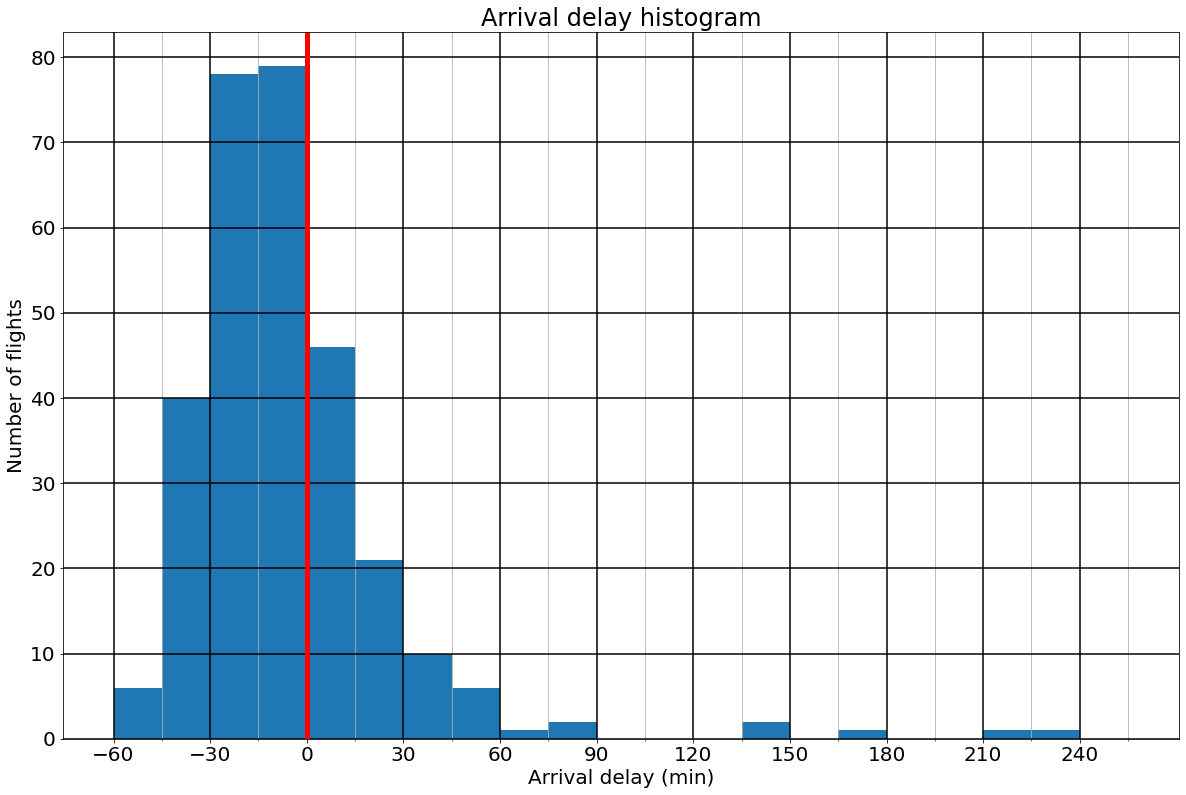

In [37]:
# ARRIVAL DEAYS
delay_cols = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Dep Delay', 'Arr Delay']

early_arrivals = past_df[past_df['Arr Delay (min)'] < 0].shape[0]
on_time_arrivals = past_df[(past_df['Arr Delay (min)'] >= 0) & (past_df['Arr Delay (min)'] < 15)].shape[0]
late_arrivals = past_df[(past_df['Arr Delay (min)'] >= 15) & (past_df['Arr Delay (min)'] < 60)].shape[0]
really_late_arrivals = past_df[past_df['Arr Delay (min)'] >= 60].shape[0]

print('Early arrivals:', early_arrivals, str(round(100*early_arrivals/NUM_PAST_FLIGHTS))+'%')
print('On time arrivals (within 15 min):', on_time_arrivals, str(round(100*on_time_arrivals/NUM_PAST_FLIGHTS))+'%')
print('Late arrivals:', late_arrivals, str(round(100*late_arrivals/NUM_PAST_FLIGHTS))+'%')
print('Really late arrivals (1+hour):', really_late_arrivals, str(round(100*really_late_arrivals/NUM_PAST_FLIGHTS))+'%')

bins = list(range(-60, math.ceil(past_df['Arr Delay (min)'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(past_df['Arr Delay (min)'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Arrival delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Arrival delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/arrival_delay.jpg', bbox_inches='tight')


past_df.sort_values('Arr Delay (min)', ascending=False).head(10).reset_index()[delay_cols]


Early departures: 5 2%
On time departures (within 15 min): 111 38%
Late departures: 160 54%
Really late departures (1+hour): 18 6%


,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Dep Time (Local),Actual Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Dep Delay,Arr Delay
0,2020-08-28 23:45:00,2020-08-29 06:51:00,2020-08-29 04:15:00,2020-08-29 10:43:00,0 days 04:28:00,United,UA1104,ANC,DEN,0 days 04:30:00,0 days 03:52:00
1,2022-08-04 20:30:00,2022-08-04 23:41:00,2022-08-05 00:33:00,2022-08-05 02:29:00,0 days 04:56:00,United,UA1257,EWR,SFO,0 days 04:03:00,0 days 02:48:00
2,2018-06-02 21:05:00,2018-06-02 23:20:00,2018-06-03 01:02:00,2018-06-03 03:00:00,0 days 01:58:00,Hainan,HU7178,HGH,PEK,0 days 03:57:00,0 days 03:40:00
3,2017-03-11 12:00:00,2017-03-12 15:00:00,2017-03-11 15:44:00,2017-03-12 17:28:00,0 days 12:44:00,United,UA89,EWR,PEK,0 days 03:44:00,0 days 02:28:00
4,2021-06-04 15:10:00,2021-06-04 16:21:00,2021-06-04 18:00:00,2021-06-04 18:47:00,0 days 00:47:00,United,UA3433,EWR,BOS,0 days 02:50:00,0 days 02:26:00
5,2022-12-11 09:20:00,2022-12-12 17:30:00,2022-12-11 11:46:00,2022-12-12 18:28:00,0 days 07:42:00,Air New Zealand,NZ9,HNL,AKL,0 days 02:26:00,0 days 00:58:00
6,2019-12-18 20:30:00,2019-12-19 18:00:00,2019-12-18 22:44:00,2019-12-19 19:17:00,0 days 13:33:00,United,UA1122,EWR,CPT,0 days 02:14:00,0 days 01:17:00
7,2018-04-02 15:30:00,2018-04-02 17:35:00,2018-04-02 17:31:00,2018-04-02 18:35:00,0 days 05:04:00,Wow,WW125,KEF,BOS,0 days 02:01:00,0 days 01:00:00
8,2020-02-19 06:46:00,2020-02-19 08:25:00,2020-02-19 08:35:00,2020-02-19 09:51:00,0 days 01:16:00,JetBlue,B6159,BOS,PHL,0 days 01:49:00,0 days 01:26:00
9,2017-07-19 22:10:00,2017-07-20 00:30:00,2017-07-19 23:50:00,2017-07-20 01:27:00,0 days 01:37:00,Hainan,HU7610,PVG,PEK,0 days 01:40:00,0 days 00:57:00


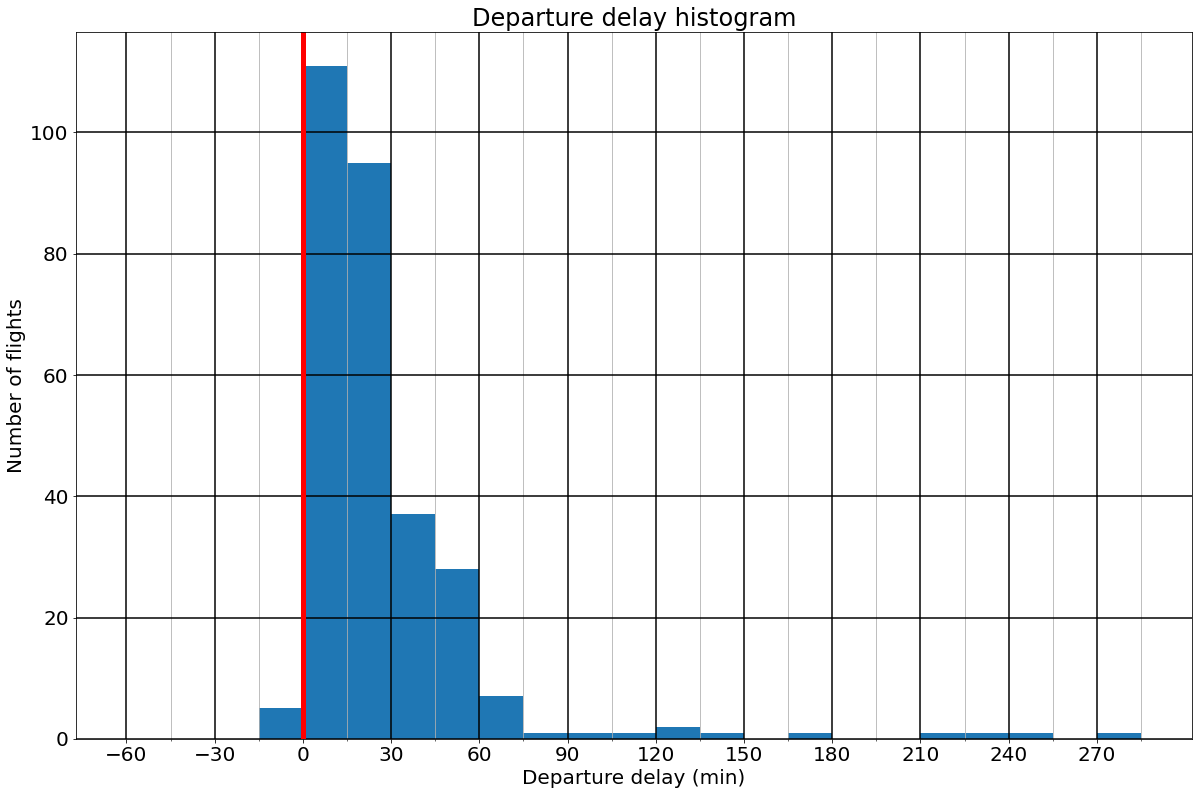

In [38]:
# DEPARTURE DELAYS

early_departures = past_df[past_df['Dep Delay (min)'] < 0].shape[0]
on_time_departures = past_df[(past_df['Dep Delay (min)'] >= 0) & (past_df['Dep Delay (min)'] < 15)].shape[0]
late_departures = past_df[(past_df['Dep Delay (min)'] >= 15) & (past_df['Dep Delay (min)'] < 60)].shape[0]
really_late_departures = past_df[past_df['Dep Delay (min)'] >= 60].shape[0]


print('Early departures:', early_departures, str(round(100*early_departures/NUM_PAST_FLIGHTS))+'%')
print('On time departures (within 15 min):', on_time_departures, str(round(100*on_time_departures/NUM_PAST_FLIGHTS))+'%')
print('Late departures:', late_departures, str(round(100*late_departures/NUM_PAST_FLIGHTS))+'%')
print('Really late departures (1+hour):', really_late_departures, str(round(100*really_late_departures/NUM_PAST_FLIGHTS))+'%')

bins = list(range(-60, math.ceil(past_df['Dep Delay (min)'].max()/30)*30+30, 15))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(past_df['Dep Delay (min)'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Departure delay (min)')
ax.set_ylabel('Number of flights')
ax.set_title('Departure delay histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/departure_delay.jpg', bbox_inches='tight')

past_df.sort_values('Dep Delay (min)', ascending=False).head(10).reset_index()[delay_cols]


In [39]:
# Earliest arriving flights
delay_cols = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Dep Delay (min)', 'Arr Delay (min)']
past_df.sort_values('Arr Delay (min)', ascending=True).head(10).reset_index()[delay_cols]


,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Dep Time (Local),Actual Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Dep Delay (min),Arr Delay (min)
0,2017-06-28 12:30:00,2017-06-28 13:35:00,2017-06-28 12:30:00,2017-06-28 12:40:00,0 days 01:10:00,China Southern,CZ318,GMP,PEK,0.0,-55.0
1,2017-12-20 12:00:00,2017-12-21 15:00:00,2017-12-20 12:15:00,2017-12-21 14:09:00,0 days 12:54:00,United,UA89,EWR,PEK,15.0,-51.0
2,2021-11-27 09:55:00,2021-11-27 14:55:00,2021-11-27 10:34:00,2021-11-27 14:05:00,0 days 11:31:00,TAP,TP237,LIS,SFO,39.0,-50.0
3,2023-07-11 16:50:00,2023-07-11 11:15:00,2023-07-11 17:00:00,2023-07-11 10:26:00,0 days 09:26:00,United,UA34,KIX,SFO,10.0,-49.0
4,2020-01-19 16:55:00,2020-01-19 19:10:00,2020-01-19 16:55:00,2020-01-19 18:23:00,0 days 01:28:00,Air China,CA1611,PEK,HRB,0.0,-47.0
5,2023-01-20 08:35:00,2023-01-20 12:02:00,2023-01-20 08:41:00,2023-01-20 11:15:00,0 days 05:34:00,United,UA731,PHL,SFO,6.0,-47.0
6,2018-11-23 10:09:00,2018-11-23 14:45:00,2018-11-23 10:19:00,2018-11-23 14:00:00,0 days 02:41:00,United,UA5481,ORD,NAS,10.0,-45.0
7,2016-01-02 18:25:00,2016-01-02 19:05:00,2016-01-02 18:48:00,2016-01-02 18:23:00,0 days 12:35:00,United,UA808,PEK,IAD,23.0,-42.0
8,2023-03-29 18:00:00,2023-03-29 21:10:00,2023-03-29 18:12:00,2023-03-29 20:29:00,0 days 07:17:00,United,UA921,LHR,EWR,12.0,-41.0
9,2016-03-13 16:50:00,2016-03-14 19:05:00,2016-03-13 16:58:00,2016-03-14 18:24:00,0 days 13:26:00,Hainan,HU482,BOS,PEK,8.0,-41.0


In [40]:
# Earliest departing flights
past_df.sort_values('Dep Delay (min)', ascending=True).head(10).reset_index()[delay_cols]




,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Dep Time (Local),Actual Arr Time (Local),Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Dep Delay (min),Arr Delay (min)
0,2024-03-10 17:40:00,2024-03-10 19:00:00,2024-03-10 17:26:00,2024-03-10 18:34:00,0 days 01:08:00,China Southern,CZ6614,KJI,URC,-14.0,-26.0
1,2020-03-15 12:47:00,2020-03-15 15:00:00,2020-03-15 12:39:00,2020-03-15 14:31:00,0 days 01:52:00,Delta,DL2667,BOS,DTW,-8.0,-29.0
2,2023-12-16 19:55:00,2023-12-16 21:00:00,2023-12-16 19:48:00,2023-12-16 20:43:00,0 days 00:55:00,LOT,LO526,PRG,WAW,-7.0,-17.0
3,2019-11-28 08:20:00,2019-11-28 20:50:00,2019-11-28 08:14:00,2019-11-28 20:40:00,0 days 07:26:00,United,UA122,IAD,LHR,-6.0,-10.0
4,2024-03-10 20:30:00,2024-03-11 00:15:00,2024-03-10 20:29:00,2024-03-10 23:54:00,0 days 01:25:00,China Southern,CZ6909,URC,PKX,-1.0,-21.0
5,2024-04-11 18:00:00,2024-04-12 06:20:00,2024-04-11 18:00:00,2024-04-12 06:20:00,0 days 07:20:00,United,UA110,EWR,LHR,0.0,0.0
6,2019-05-30 07:55:00,2019-05-30 11:40:00,2019-05-30 07:55:00,2019-05-30 11:16:00,0 days 03:21:00,Air China,CA1469,PEK,LJG,0.0,-24.0
7,2016-03-24 20:50:00,2016-03-24 22:50:00,2016-03-24 20:50:00,2016-03-24 22:15:00,0 days 01:25:00,China Eastern,MU2117,XIY,PEK,0.0,-35.0
8,2020-01-19 16:55:00,2020-01-19 19:10:00,2020-01-19 16:55:00,2020-01-19 18:23:00,0 days 01:28:00,Air China,CA1611,PEK,HRB,0.0,-47.0
9,2024-04-10 23:05:00,2024-04-11 08:10:00,2024-04-10 23:05:00,2024-04-11 08:10:00,0 days 08:05:00,United,UA887,LIM,EWR,0.0,0.0


In [41]:
# Arrival delay by year
past_df.groupby(past_df['Date'].dt.year)['Arr Delay (min)'].aggregate(
    count='count', 
    early_flights=lambda x: x[x<=0].count(),
    late_flights=lambda x: x[x>0].count(),
    percent_early=lambda x: 100*(x[x<=0].count()/len(x)),
    avg_gained_time=lambda x: x[x <= 0].mean(), 
    avg_lost_time=lambda x: x[x > 0].mean(), 
    avg_net_time_lost='mean',
    total_net_time_lost=sum).fillna(0).round().astype(int, errors='ignore')


,count,early_flights,late_flights,percent_early,avg_gained_time,avg_lost_time,avg_net_time_lost,total_net_time_lost
Date,,,,,,,,
2015,11,5,6,45,-18,22,4,40
2016,22,16,6,73,-21,5,-14,-308
2017,39,28,11,72,-24,36,-7,-284
2018,26,19,7,73,-19,59,2,55
2019,32,24,8,75,-16,27,-6,-178
2020,30,22,8,73,-24,47,-5,-159
2021,33,24,9,73,-17,29,-5,-157
2022,35,24,11,69,-18,37,-1,-34
2023,44,35,9,80,-21,20,-13,-566


In [42]:
# Arrival delay by airline
top_airlines = past_df.groupby('Airline').agg({'Date': 'count'})
top_airlines = top_airlines[top_airlines['Date'] >= 5].index.tolist()
filtered_rows = past_df[past_df['Airline'].isin(top_airlines)]
arrival_delay_by_airline = filtered_rows.groupby(filtered_rows['Airline'])['Arr Delay (min)'].aggregate(
    count='count', 
    early_flights=lambda x: x[x<=0].count(),
    late_flights=lambda x: x[x>0].count(),
    percent_early=lambda x: 100*(x[x<=0].count()/len(x)),
    avg_gained_time=lambda x: x[x <= 0].mean(), 
    avg_lost_time=lambda x: x[x > 0].mean(), 
    avg_net_time_lost='mean').sort_values('percent_early', ascending=False)

arrival_delay_by_airline.fillna(0).round().astype(int, errors='ignore')


,count,early_flights,late_flights,percent_early,avg_gained_time,avg_lost_time,avg_net_time_lost
Airline,,,,,,,
Delta,8,8,0,100,-24,0,-24
American,5,4,1,80,-25,11,-18
United,154,121,33,79,-21,35,-9
JetBlue,9,7,2,78,-16,44,-3
Air China,15,11,4,73,-21,19,-10
China Eastern,5,3,2,60,-21,12,-7
Lufthansa,10,6,4,60,-14,18,-1
Hainan,14,8,6,57,-24,66,14
China Southern,11,6,5,55,-19,27,2


,Scheduled Dep Time (Local),Scheduled Arr Time (Local),Actual Dep Time (Local),Actual Arr Time (Local),Scheduled Duration,Actual Duration,Airline,Flight,Dep Airport,Arr Airport,Dep Delay (min),Arr Delay (min),Minutes Made Up
190,2021-11-27 09:55:00,2021-11-27 14:55:00,2021-11-27 10:34:00,2021-11-27 14:05:00,0 days 13:00:00,0 days 11:31:00,TAP,TP237,LIS,SFO,39.0,-50.0,89.0
223,2022-12-11 09:20:00,2022-12-12 17:30:00,2022-12-11 11:46:00,2022-12-12 18:28:00,0 days 09:10:00,0 days 07:42:00,Air New Zealand,NZ9,HNL,AKL,146.0,58.0,88.0
218,2022-11-10 10:40:00,2022-11-11 20:15:00,2022-11-10 11:30:00,2022-11-11 19:39:00,0 days 17:35:00,0 days 16:09:00,United,UA29,SFO,SIN,50.0,-36.0,86.0
22,2016-07-03 16:10:00,2016-07-03 16:15:00,2016-07-03 17:01:00,2016-07-03 15:42:00,0 days 13:05:00,0 days 11:41:00,United,UA850,PEK,ORD,51.0,-33.0,84.0
36,2017-03-11 12:00:00,2017-03-12 15:00:00,2017-03-11 15:44:00,2017-03-12 17:28:00,0 days 14:00:00,0 days 12:44:00,United,UA89,EWR,PEK,224.0,148.0,76.0
211,2022-08-04 20:30:00,2022-08-04 23:41:00,2022-08-05 00:33:00,2022-08-05 02:29:00,0 days 06:11:00,0 days 04:56:00,United,UA1257,EWR,SFO,243.0,168.0,75.0
269,2023-12-17 13:10:00,2023-12-18 06:35:00,2023-12-17 14:33:00,2023-12-18 06:44:00,0 days 10:25:00,0 days 09:11:00,LOT,LO91,WAW,PEK,83.0,9.0,74.0
70,2017-12-20 12:00:00,2017-12-21 15:00:00,2017-12-20 12:15:00,2017-12-21 14:09:00,0 days 14:00:00,0 days 12:54:00,United,UA89,EWR,PEK,15.0,-51.0,66.0
11,2016-01-02 18:25:00,2016-01-02 19:05:00,2016-01-02 18:48:00,2016-01-02 18:23:00,0 days 13:40:00,0 days 12:35:00,United,UA808,PEK,IAD,23.0,-42.0,65.0
260,2023-09-30 23:20:00,2023-10-02 05:00:00,2023-09-30 23:54:00,2023-10-02 04:29:00,0 days 14:40:00,0 days 13:35:00,United,UA877,SFO,HKG,34.0,-31.0,65.0


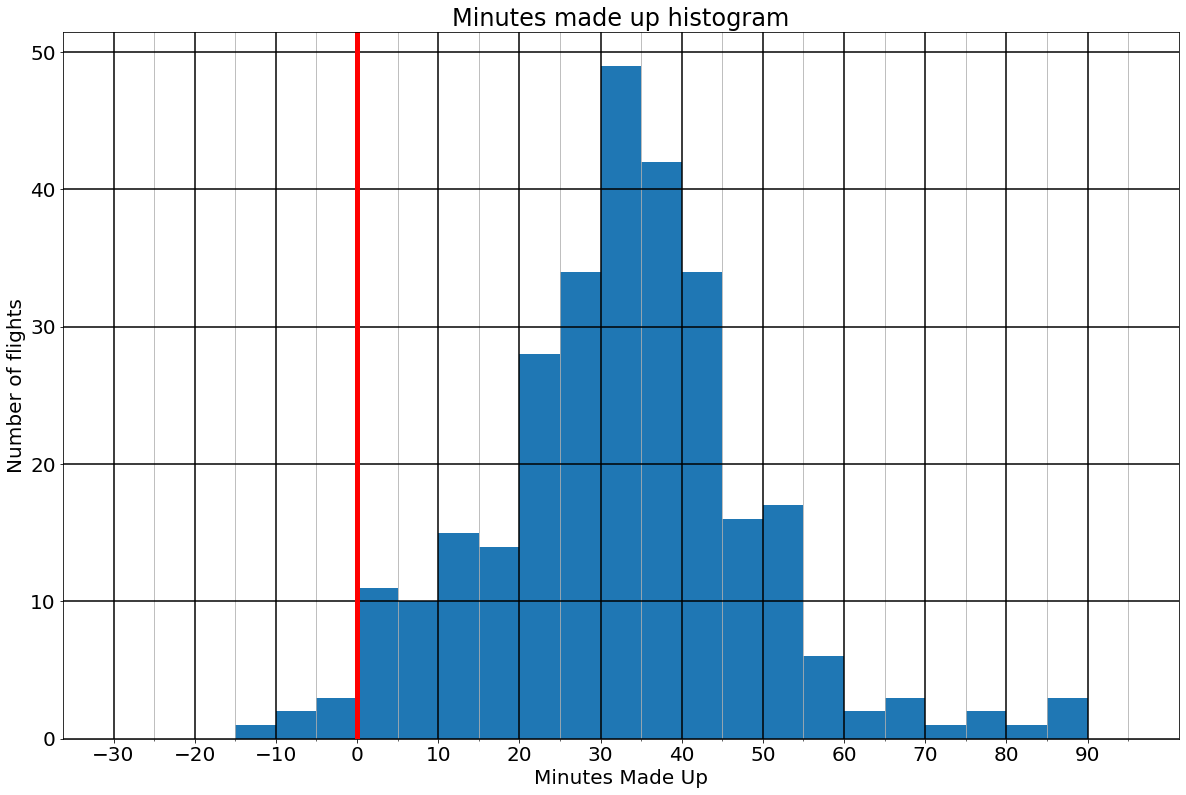

In [43]:
# Top flights in making up time
delay_cols = ['Scheduled Dep Time (Local)', 'Scheduled Arr Time (Local)', 'Actual Dep Time (Local)', 'Actual Arr Time (Local)', 'Scheduled Duration', 'Actual Duration', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Dep Delay (min)', 'Arr Delay (min)', 'Minutes Made Up']

bins = list(range(-30, math.ceil(past_df['Minutes Made Up'].max()/10)*10+10, 5))
fig, ax = plt.subplots(figsize=(20,13))
ax.hist(past_df['Minutes Made Up'], bins=bins)
ax.set_xticks(bins, minor=True)
ax.set_xticks([b for i, b in enumerate(bins) if b%2 == 0])
ax.grid(which='major', linewidth=1.5, color='black')
ax.grid(which='minor', axis='both')
ax.set_xlabel('Minutes Made Up')
ax.set_ylabel('Number of flights')
ax.set_title('Minutes made up histogram')
ax.axvline(0, linewidth=5, color='red')
plt.savefig('figures/minutes_made_up.jpg', bbox_inches='tight')

past_df.sort_values('Minutes Made Up', ascending=False).head(10)[delay_cols]


In [44]:
# Making up time by year

In [45]:
# Making up time by airline

# DEPARTURE/ARRIVAL TIMES

Morning flights (5a-12p): 109, 36%
Afternoon flights (12p-6p): 102, 33%
Evening flights (6p-11p): 75, 25%
Late nights flights (11p-5a): 19, 6%


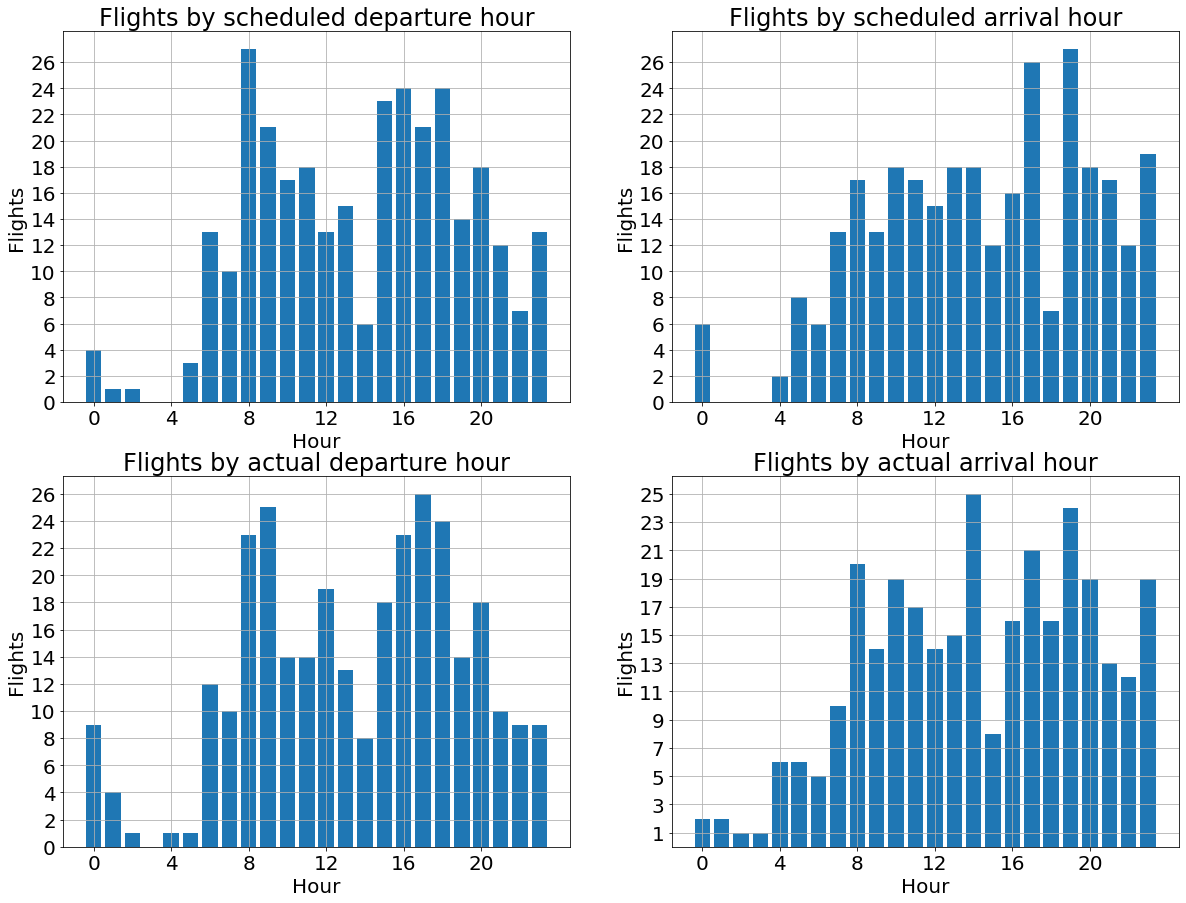

In [46]:
morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

print('Morning flights (5a-12p): ' + str(morning_flights) + ', ' + str(int(round(100*morning_flights/NUM_FLIGHTS))) + '%')
print('Afternoon flights (12p-6p): ' + str(afternoon_flights) + ', ' + str(int(round(100*afternoon_flights/NUM_FLIGHTS))) + '%')
print('Evening flights (6p-11p): ' + str(evening_flights) + ', ' + str(int(round(100*evening_flights/NUM_FLIGHTS))) + '%')
print('Late nights flights (11p-5a): ' + str(late_night_flights) + ', ' + str(int(round(100*late_night_flights/NUM_FLIGHTS))) + '%')

df['Scheduled dep hour'] = df['Scheduled Dep Time (Local)'].dt.hour
df['Scheduled arr hour'] = df['Scheduled Arr Time (Local)'].dt.hour
df['Actual dep hour'] = df['Actual Dep Time (Local)'].dt.hour
df['Actual arr hour'] = df['Actual Arr Time (Local)'].dt.hour

scheduled_dep_hour = df.groupby('Scheduled dep hour') .agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_dep_hour['Hour']):
    scheduled_dep_hour = pd.concat([scheduled_dep_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
scheduled_dep_hour = scheduled_dep_hour.sort_values(by='Hour')

scheduled_arr_hour = df.groupby('Scheduled arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Scheduled arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(scheduled_arr_hour['Hour']):
    scheduled_arr_hour = pd.concat([scheduled_arr_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
scheduled_arr_hour = scheduled_arr_hour.sort_values(by='Hour')

actual_dep_hour = df.groupby('Actual dep hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual dep hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_dep_hour['Hour']):
    actual_dep_hour = pd.concat([actual_dep_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
actual_dep_hour = actual_dep_hour.sort_values(by='Hour')

actual_arr_hour = df.groupby('Actual arr hour').agg({'Date': 'count'}).reset_index().rename(columns={'Actual arr hour': 'Hour', 'Date': 'Count'})
for h in set(range(0, 24)) - set(actual_arr_hour['Hour']):
    actual_arr_hour = pd.concat([actual_arr_hour, pd.DataFrame({'Hour': h, 'Count': 0}, index=[0])])
actual_arr_hour = actual_arr_hour.sort_values(by='Hour')

fig, ax = plt.subplots(2, 2, figsize=(20,15))
ax[0, 0].bar(scheduled_dep_hour['Hour'], scheduled_dep_hour['Count'], linewidth=5)
ax[0, 0].grid(True)
ax[0, 0].set_xticks(range(0,24,4))
ax[0, 0].set_xlabel('Hour')
ax[0, 0].set_yticks(np.arange(min(scheduled_dep_hour['Count']), max(scheduled_dep_hour['Count'])+1, 2.0))
ax[0, 0].set_ylabel('Flights')
ax[0, 0].set_title('Flights by scheduled departure hour')

ax[1, 0].bar(actual_dep_hour['Hour'], actual_dep_hour['Count'], linewidth=5)
ax[1, 0].grid(True)
ax[1, 0].set_xticks(range(0,24,4))
ax[1, 0].set_xlabel('Hour')
ax[1, 0].set_yticks(np.arange(min(actual_dep_hour['Count']), max(actual_dep_hour['Count'])+1, 2.0))
ax[1, 0].set_ylabel('Flights')
ax[1, 0].set_title('Flights by actual departure hour')

ax[0, 1].bar(scheduled_arr_hour['Hour'], scheduled_arr_hour['Count'], linewidth=5)
ax[0, 1].grid(True)
ax[0, 1].set_xticks(range(0,24,4))
ax[0, 1].set_xlabel('Hour')
ax[0, 1].set_yticks(np.arange(min(scheduled_arr_hour['Count']), max(scheduled_arr_hour['Count'])+1, 2.0))
ax[0, 1].set_ylabel('Flights')
ax[0, 1].set_title('Flights by scheduled arrival hour')

ax[1, 1].bar(actual_arr_hour['Hour'], actual_arr_hour['Count'], linewidth=5)
ax[1, 1].grid(True)
ax[1, 1].set_xticks(range(0,24,4))
ax[1, 1].set_xlabel('Hour')
ax[1, 1].set_yticks(np.arange(min(actual_arr_hour['Count']), max(actual_arr_hour['Count'])+1, 2.0))
ax[1, 1].set_ylabel('Flights')
ax[1, 1].set_title('Flights by actual arrival hour')
plt.savefig('figures/by_hour.jpg', bbox_inches='tight')



# ROUTES

In [47]:
import pyproj
from geojson import LineString, Feature, FeatureCollection, dump
import geopy.distance


def get_hist(x):
    dct = {a: x.tolist().count(a) for a in x.tolist()}
    return ';'.join([str(list(dct.keys())[i]) + ',' + str(list(dct.values())[i]) for i in range(len(dct))])


def augment_routes(df):
    route_grouped = df.groupby('Sorted Route')
    df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
    df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
    df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
    df['route_airline_hist'] = route_grouped['Airline'].transform(get_hist)
    df['route_flight_string'] = route_grouped['Flight'].transform(lambda x: ';'.join(x))
    df['route_origin_hist'] = route_grouped['Dep Airport'].transform(get_hist)
    grouped = df.groupby('Sorted Route').first()[['Distance', 'Actual Duration (min)', 'Domestic/International',
                                        'route_date_string', 'route_class_hist', 'route_airline_hist', 'route_flight_string', 'route_origin_hist'
                                       ]]
    grouped['count'] = grouped['route_date_string'].apply(lambda x: len(x.split(';')))

    grouped = grouped.reset_index()
    grouped['Dep IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[0])
    grouped['Arr IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[1])
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Dep IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'City': 'Dep City', 'Country': 'Dep Country', 'Lat': 'Dep Lat', 'Long': 'Dep Long'})
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Arr IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'City': 'Arr City', 'Country': 'Arr Country', 'Lat': 'Arr Lat', 'Long': 'Arr Long'})

    return grouped




def get_path(startlong, startlat, endlong, endlat):
    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                     1 + int(dist / 5000))
    
    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))
    offset = 0
    for i in range(len(lonlats)-1):
        if lonlats[i][0] > 0 and lonlats[i+1][0] < 0 and lonlats[i+1][0] < -170:
            offset = 360
        elif lonlats[i][0] < 0 and lonlats[i+1][0] > 0 and lonlats[i+1][0] > 170:
            offset = -360
        lonlats[i+1] = (lonlats[i+1][0] + offset , lonlats[i+1][1])
#     print(len(lonlats))
    return LineString(lonlats)


def make_route_geojson(df, path):
    
    grouped = augment_routes(df)
    
    features = []
    for i, row in grouped.iterrows():
    #     lats = row['Sorted Lat'].split(';')
    #     longs = row['Sorted Long'].split(';')
        properties = properties = {'start_iata': row['Dep IATA'], 
                              'start_name': row['Dep Name'], 
                              'start_city_country': row['Dep City'] + ', ' + row['Dep Country'], 
                              'end_iata': row['Arr IATA'], 
                              'end_name': row['Arr Name'], 
                              'end_city_country': row['Arr City'] + ', ' + row['Arr Country'],  
                              'dist': row['Distance'], 
                              'dur': row['Actual Duration (min)'],
                              'domint': row['Domestic/International'],
                              'count': row['count'],
                              'earliest_date': row['route_date_string'].split(';')[0].split(' ')[0],
                              'latest_date': row['route_date_string'].split(';')[-1].split(' ')[0],
                              'date_string': row['route_date_string'],
                              'class_hist': row['route_class_hist'],
                              'airline_hist': row['route_airline_hist'],
                              'flight_string': row['route_flight_string'],
                              'origin_hist': row['route_origin_hist']
                             }
        features.append(Feature(geometry=get_path(row['Dep Long'], row['Dep Lat'], 
                                                  row['Arr Long'], row['Arr Lat']),
                                properties = properties))
    fc = FeatureCollection(features)

    with open(path, 'w') as f:
        dump(fc, f)



# AIRPORTS AUGMENTED

In [48]:
from geojson import Point, Feature, FeatureCollection, dump

def augment_airports(df):
    df['Year'] = df['Date'].dt.year

    dep_grouped = df.groupby('Dep Airport')
    df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
    df['dep_count'] = dep_grouped['Date'].transform(lambda v: v.shape[0])
    df['dep_first'] = dep_grouped['Date'].transform(lambda v: min(v))
    df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
    df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
    df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
    df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)

    arr_grouped = df.groupby('Arr Airport')
    df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
    df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
    df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
    df['arr_last'] = arr_grouped['Date'].transform(lambda v: max(v))
    df['arr_conn_count'] = arr_grouped['Arr Connect'].transform(lambda v: int(v.sum())).astype('int')
    df['arr_airline_hist'] = arr_grouped['Airline'].transform(get_hist)
    df['arr_intdom_hist'] = arr_grouped['Domestic/International'].transform(get_hist)
    df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)

    df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)

    df = df.drop(columns='arr_conn_year_hist').merge(df[['Arr Airport', 'arr_conn_year_hist']].dropna().drop_duplicates(), on='Arr Airport', how='left')

    deps = df.groupby('Dep Airport').first()[['Dep Name', 'Dep City', 'Dep Country', 'Dep Lat', 'Dep Long',
                                       'dep_dest_hist', 'dep_count', 'dep_first', 'dep_last', 'dep_airline_hist', 'dep_intdom_hist', 'dep_year_hist'
                                      ]].reset_index()
    arrcons = df.groupby('Arr Airport').first()[['Arr Name', 'Arr City', 'Arr Country', 'Arr Lat', 'Arr Long',
                                                 'arr_dest_hist', 'arr_count', 'arr_first', 'arr_last', 'arr_airline_hist', 'arr_intdom_hist', 'arr_year_hist',
                                       'arr_conn_count', 'arr_conn_year_hist'
                                      ]].reset_index()
    airports_aug = deps.merge(arrcons, left_on='Dep Airport', right_on='Arr Airport', how='outer')
    
    def merge_names(row):
        for col in ['Airport', 'Name', 'City', 'Country']:
            row[col] = row['Dep '+ col] if type(row['Dep '+ col]) == str else row['Arr '+ col]
        for col in ['Lat', 'Long']:
            row[col] = row['Dep '+ col] if not np.isnan(row['Dep '+ col]) else row['Arr '+ col]
        return row


    airports_aug = airports_aug.apply(merge_names, axis=1)
    airports_aug = airports_aug.rename(columns={'Airport': 'IATA'})

    airports_aug = airports_aug[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long',
                                 'dep_count', 'arr_count', 'arr_conn_count',
                                 'dep_dest_hist', 'arr_dest_hist',
                                 'dep_first', 'arr_first', 'dep_last', 'arr_last',
                                 'dep_airline_hist', 'arr_airline_hist',
                                 'dep_intdom_hist', 'arr_intdom_hist',
                                 'dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist'
                                ]]
    airports_aug['dep_count'] = airports_aug['dep_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)
    airports_aug['arr_count'] = airports_aug['arr_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)

    def subtract_hist(row):
        dep_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['dep_year_hist'].split(';')} if row['dep_year_hist'] != '' else {}
        arr_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_year_hist'].split(';')} if row['arr_year_hist'] != '' else {}
        conn_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_conn_year_hist'].split(';')} if row['arr_conn_year_hist'] != '' else {}

        for year in conn_hist:
            if year in dep_hist:
                dep_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in dep')
            if year in arr_hist:
                arr_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in arr')

        row['dep_year_hist'] = ';'.join([str(x) + ',' + str(dep_hist[x]) for x in dep_hist if dep_hist[x] > 0])
        row['arr_year_hist'] = ';'.join([str(x) + ',' + str(arr_hist[x]) for x in arr_hist if arr_hist[x] > 0])
        full_year_hist = {}
        for key in dep_hist:
            full_year_hist[key] = full_year_hist[key] + dep_hist[key] if key in full_year_hist else dep_hist[key]
        for key in arr_hist:
            full_year_hist[key] = full_year_hist[key] + arr_hist[key] if key in full_year_hist else arr_hist[key]
        for key in conn_hist:
            full_year_hist[key] = full_year_hist[key] + conn_hist[key] if key in full_year_hist else conn_hist[key]
        row['full_year_hist'] = ';'.join([str(x) + ',' + str(full_year_hist[x]) for x in full_year_hist if full_year_hist[x] > 0])
        return row

    airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']] = airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']].fillna('')
    airports_aug = airports_aug.apply(subtract_hist, axis=1)
    airports_aug['total'] = airports_aug['dep_count'].fillna(0) + airports_aug['arr_count'].fillna(0) + airports_aug['arr_conn_count'].fillna(0)
    airports_aug['first'] = airports_aug.apply(lambda row: min(row['dep_first'], row['arr_first']), axis=1)
    airports_aug['last'] = airports_aug.apply(lambda row: min(row['dep_last'], row['arr_last']), axis=1)
    year_airports_aug.append(airports_aug)
    return airports_aug

def make_airport_geojson(df, path):
    airports_aug = augment_airports(df)
    for col in ['dep_first', 'arr_first', 'dep_last', 'arr_last', 'first', 'last']:
        airports_aug[col] = airports_aug[col].dt.strftime('%Y-%m-%d')
    airports_aug = airports_aug.fillna('')
    features = []
    for i, row in airports_aug.iterrows():
#         print(row.drop(['Lat', 'Long']).to_dict())
        features.append(Feature(geometry=Point((row['Long'], row['Lat'])), properties=row.drop(['Lat', 'Long']).to_dict()))
    fc = FeatureCollection(features)
    with open(path, 'w') as f:
        dump(fc, f)


In [49]:
#### MAKE ROUTES
year_airports_aug = [] # first one is all

make_route_geojson(df, ROOT_DIR + 'routes_all.geojson')
make_airport_geojson(df, ROOT_DIR + 'airports_all.geojson')

all_years = df['Date'].dt.year.unique().tolist()
first_month = min(df[df['Date'].dt.year == all_years[0]]['Date'].dt.month)
last_month = max(df[df['Date'].dt.year == all_years[-1]]['Date'].dt.month)

with open(ROOT_DIR + "month_range.txt", "w") as text_file:
    text_file.write(','.join(str(x) for x in all_years) + '\n' + str(first_month) + ',' + str(last_month))

for year in all_years:
    make_route_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'routes_' + str(year) + '.geojson')
    make_airport_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'airports_' + str(year) + '.geojson')

print('years done')

for year in all_years:
    print(year)
    for month in range(1, 13):
        if year == all_years[0] and month < first_month:
            continue
        if year == all_years[-1] and month > last_month:
            continue
        print('  ', month)
        simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
        make_route_geojson(simp_df, ROOT_DIR + 'routes_cum_' + str(year) + '_' + str(month) + '.geojson')
        make_airport_geojson(simp_df, ROOT_DIR + 'airports_cum_' + str(year) + '_' + str(month) + '.geojson')
    


<ipython-input-47-9cc43f402661>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
<ipython-input-47-9cc43f402661>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
<ipython-input-47-9cc43f402661>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

<ipython-input-48-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-48-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-48-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-48-3449acb59ab2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)
<ipython-input-48-3449acb59ab2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
<ipython-input-48-3449acb59ab2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<ipython-input-47-9cc43f402661>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
<ipython-input-47-9cc43f402661>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
<ipython-input-47-9cc43f402661>:16: SettingWithCopyWarning: 
A value is trying to be set on a co

<ipython-input-48-3449acb59ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-48-3449acb59ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
<ipython-input-48-3449acb59ab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-48-3449acb59ab2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
<ipython-input-48-3449acb59ab2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
<ipython-input-48-3449acb59ab2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

<ipython-input-48-3449acb59ab2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
<ipython-input-48-3449acb59ab2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
<ipython-input-48-3449acb59ab2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

<ipython-input-47-9cc43f402661>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
<ipython-input-47-9cc43f402661>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
<ipython-input-47-9cc43f402661>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

years done
2015
   1
   2
   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4
   5
   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7
   8
   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10
   11
   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2016
   1
   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3
   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5
   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7
   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9
   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11
   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2017
   1
   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3
   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2018
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2019
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2020 not in dep
   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2021
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2022
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2023
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   8


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   9


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   10


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   11


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   12


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


2024
   1


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   2


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   3


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   4


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   5


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   6


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


   7


<ipython-input-49-6b6beb3abdea>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)


# PRINTING

In [50]:
def get_stats(df, airports_aug, year=None, ab=False):
    print(year)
    TOTAL_DIST = df['Distance'].sum()
    TOTAL_TIME = df['Actual Duration (min)'].sum()
    NUM_FLIGHTS = df['Date'].count()
    NUM_AIRLINES = df['Airline'].nunique()
    NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
    NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

    dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
    dep_countries.columns = ['Country', 'Airport', 'Departures']
    arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
    arr_countries.columns = ['Country', 'Airport', 'Arrivals']
    countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
    countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']

    routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
    routes_sorted.columns = ['Count', 'Total Distance', 'Actual Duration (min)']

    airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum, 'Actual Duration (min)': sum}).sort_values(by='Date', ascending=False)
    airlines.columns = ['Count', 'Total Distance', 'Actual Duration (min)']

    dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count', 'Actual Duration (min)': sum})
    dist_year.columns = ['Distance', 'Flights', 'Actual Duration (min)']

    dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count', 'Actual Duration (min)': sum})
    dom_int.columns = ['Distance', 'Flights', 'Actual Duration (min)']

    clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count', 'Actual Duration (min)': sum})
    clas.columns = ['Distance', 'Flights', 'Actual Duration (min)']
   
    early_arrivals = df[df['Arr Delay (min)'] < 0].shape[0]
    on_time_arrivals = df[(df['Arr Delay (min)'] >= 0) & (df['Arr Delay (min)'] < 15)].shape[0]
    late_arrivals = df[(df['Arr Delay (min)'] >= 15) & (df['Arr Delay (min)'] < 60)].shape[0]
    really_late_arrivals = df[df['Arr Delay (min)'] >= 60].shape[0]

    morning_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 5) & (df['Scheduled Dep Time (Local)'].dt.hour <= 11)].shape[0]
    afternoon_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 12) & (df['Scheduled Dep Time (Local)'].dt.hour <= 17)].shape[0]
    evening_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 18) & (df['Scheduled Dep Time (Local)'].dt.hour <= 22)].shape[0]
    late_night_flights = df[(df['Scheduled Dep Time (Local)'].dt.hour >= 23) | (df['Scheduled Dep Time (Local)'].dt.hour <= 4)].shape[0]

    def get_time(minutes):
        return [int(minutes//60), int(minutes % 60)]

    def get_time_str(minutes):
        if get_time(minutes)[0] == 0:
            return str(get_time(minutes)[1]) + 'min'
        else:
            return str(get_time(minutes)[0]) + 'h ' + str(get_time(minutes)[1]) + 'm'

        
    big_str = ''
    if ab:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(first_month) + '/' + str(all_years[0]) + '-' + str(last_month) + '/' + str(all_years[-1]) + ')</span></h2>'
    else:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(year) + ')</span></h2>'
        
    big_str += '<p>Total Distance Flown: <span class=\'bold\'>' + '{:,}'.format(TOTAL_DIST).split('.')[0] + '</span>mi' + '\n'
    big_str += '<br>Total Time in Air: <span class=\'bold\'>' + str(timedelta(minutes=int(TOTAL_TIME))) + '</span>' + '\n'
    big_str += '<br>Total Flights: <span class=\'bold\'>' + str(NUM_FLIGHTS) + '</span>' + '\n'
    big_str += '<br>Number of Airlines: <span class=\'bold\'>' + str(NUM_AIRLINES) + '</span>'
    big_str += ', Countries: <span class=\'bold\'>' + str(NUM_COUNTRIES) + '</span>'
    big_str += ', Airports: <span class=\'bold\'>' + str(NUM_AIRPORTS) + '</span>' + '\n'
    big_str += '<p>Longest interval between flights: <span class=\'bold\'>' + str(LONGEST_INTERVAL) + '</span> (' + str(LONGEST_INTERVAL_0) + ' to ' + str(LONGEST_INTERVAL_1) + ')\n'
    big_str += '<br>Month with most flying: <span class=\'bold\'>' 
    big_str += str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Flights', ascending=False).reset_index().loc[0, 'Actual Duration (min)']) + ') or <span class=\'bold\'>'
    big_str += str(a.sort_values('Actual Duration (min)', ascending=False).reset_index().loc[0, 'Y-M']) + '</span> (' 
    big_str += str(int(a.sort_values('Actual Duration (min)', ascending=False).reset_index().loc[0, 'Flights'])) + ' flights, '
    big_str += get_time_str(a.sort_values('Actual Duration (min)', ascending=False).reset_index().loc[0, 'Actual Duration (min)']) + ')\n'


    by_dist = df[df['Actual Duration (min)'] != 0.0].sort_values(by='Actual Duration (min)')
    print(by_dist)
    big_str += ('<p>Shortest flight: <span class=\'bold\'>' + by_dist.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist.iloc[0]['Actual Duration (min)']) + ')' + '\n')


    by_dist2 = df.sort_values(by='Actual Duration (min)', ascending=False)
    big_str += ('<br>Longest flight: <span class=\'bold\'>' + by_dist2.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist2.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + '{:,}'.format(by_dist2.iloc[0]['Distance']).split('.')[0] + 'mi, ' + get_time_str(by_dist2.iloc[0]['Actual Duration (min)']) + ')</p>' + '\n')

    countries_list = countries.reset_index().groupby('Country').count().reset_index()[['Country', 'Airport']].sort_values(by='Airport', ascending=False).values.tolist()
    country_airport = '<p>Airport distribution (top countries): '
    for country, airports in countries_list[:5]:
        country_airport += '<span class=\'bold\'>' + country + '</span>: ' + str(airports) + ', '
    country_airport = country_airport[:-2]
    big_str += country_airport + '\n'

    # visited_airports
    visited_list = airports_aug.sort_values(by='total', ascending=False)[['IATA', 'total']].values.tolist()
    visited_airports = '<br>Airports by total visits: '
    for airport, total in visited_list[:5]:
        visited_airports += '<span class=\'bold\'>' + airport + '</span>: ' + str(int(total)) + ', '
    visited_airports = visited_airports[:-2]
    big_str += visited_airports + '\n'

    routes_list = routes_sorted.reset_index()[['Sorted Route', 'Count']].values.tolist()
    top_routes = '<br>Top routes: '
    for route, count in routes_list[:5]:
        top_routes += '<span class=\'bold\'>' + route.split(' ')[0] + '</span> to <span class=\'bold\'>' + route.split(' ')[1] + '</span>: ' + str(int(count)) + ', '
    top_routes = top_routes[:-2]
    big_str += top_routes + '\n'

    airlines_list = airlines.reset_index()[['Airline', 'Count']].values.tolist()
    top_airlines = '<br>Top airlines: '
    for airline, count in airlines_list[:5]:
        top_airlines += '<span class=\'bold\'>' + airline + '</span>: ' + str(int(count)) + ', '
    top_airlines = top_airlines[:-2]
    big_str += top_airlines + '\n'

    big_str += '<p>Early arrivals: <span class=\'bold\'>' + str(early_arrivals) + '</span> (' + str(round(100*early_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>On-time arrivals (within 15min): <span class=\'bold\'>' + str(on_time_arrivals) + '</span> (' + str(round(100*on_time_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late arrivals (up to 1hr delay): <span class=\'bold\'>' + str(late_arrivals) + '</span> (' + str(round(100*late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Really late arrivals (>1hr delay): <span class=\'bold\'>' + str(really_late_arrivals) + '</span> (' + str(round(100*really_late_arrivals/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    big_str += '<p>Morning flights (5am-12p): <span class=\'bold\'>' + str(morning_flights) + '</span> (' + str(round(100*morning_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Afternoon flights (12p-6p): <span class=\'bold\'>' + str(afternoon_flights) + '</span> (' + str(round(100*afternoon_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Evening flights (6p-11p): <span class=\'bold\'>' + str(evening_flights) + '</span> (' + str(round(100*evening_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '<br>Late night flights (11p-5a): <span class=\'bold\'>' + str(late_night_flights) + '</span> (' + str(round(100*late_night_flights/NUM_FLIGHTS))+'%)\n'
    big_str += '</p>\n'
    
    dom_int_list = dom_int.reset_index()[['Domestic/International', 'Distance', 'Flights']].values.tolist()
    domint = '<p>'
    for di, dist, count in dom_int_list:
        domint += '<span class=\'bold\'>' + di + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    domint = domint[:-5] + '</p>'
    big_str += domint + '\n'

    class_list = clas.reset_index()[['Class', 'Distance', 'Flights']].values.tolist()
    class_str = '<p>'
    for c, dist, count in class_list:
        class_str += '<span class=\'bold\'>' + c + '</span>: ' + '{:,}'.format(dist).split('.')[0] + 'mi, ' + str(int(count)) + ' flights\n<br>'
    class_str = class_str[:-5] + '</p>'
    big_str += class_str + '\n'
    
    if ab: # ind years don't need this
        print(dist_year.reset_index())
        years_list = dist_year.reset_index()[['Date', 'Distance', 'Flights', 'Actual Duration (min)']].values.tolist()
        years = '<p>'
        for year, dist, count, dur in years_list:
            years += '<span class=\'bold\'>' + str(int(year)) + '</span>: ' + get_time_str(dur) + ', ' + str(int(count)) + ' flights, ' + '{:,}'.format(dist).split('.')[0] + 'mi \n<br>'
        years = years[:-5] + '</p>'
        big_str += years + '\n'

#     print(big_str)
    return big_str

big_str = get_stats(df, year_airports_aug[0], ab=True)
with open(ROOT_DIR + "all_stats.txt", "w") as text_file:
    text_file.write(big_str)
for i, year in enumerate(all_years):
    big_str = get_stats(df[df['Date'].dt.year == year], year_airports_aug[i+1], year=year)
    with open(ROOT_DIR + str(year) + "_stats.txt", "w") as text_file:
        text_file.write(big_str)

None
          Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
65  2017-11-13        2017-11-13 06:00:00        2017-11-13 07:03:00   
194 2022-01-03        2022-01-03 18:10:00        2022-01-03 19:10:00   
58  2017-09-22        2017-09-22 08:30:00        2017-09-22 09:32:00   
142 2020-05-20        2020-05-20 18:30:00        2020-05-20 19:48:00   
59  2017-09-24        2017-09-24 17:05:00        2017-09-24 18:25:00   
38  2017-03-20        2017-03-20 21:52:00        2017-03-20 23:05:00   
244 2023-04-22        2023-04-22 08:15:00        2023-04-22 09:30:00   
111 2019-07-08        2019-07-08 08:00:00        2019-07-08 09:18:00   
27  2016-12-15        2016-12-15 09:15:00        2016-12-15 10:35:00   
66  2017-11-13        2017-11-13 09:00:00        2017-11-13 10:24:00   
118 2019-09-28        2019-09-28 20:30:00        2019-09-28 21:47:00   
161 2021-01-17        2021-01-17 18:15:00        2021-01-17 19:27:00   
4   2015-03-19        2015-03-19 20:32:00        2015-03-19

2018
         Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
90 2018-10-09        2018-10-09 19:15:00        2018-10-09 20:31:00   
94 2018-11-26        2018-11-26 19:25:00        2018-11-26 20:42:00   
87 2018-10-03        2018-10-03 09:45:00        2018-10-03 11:02:00   
79 2018-05-27        2018-05-27 09:15:00        2018-05-27 11:25:00   
86 2018-06-07        2018-06-07 22:24:00        2018-06-07 23:59:00   
80 2018-05-28        2018-05-28 12:05:00        2018-05-28 13:25:00   
81 2018-05-30        2018-05-30 13:45:00        2018-05-30 15:45:00   
83 2018-06-02        2018-06-02 08:35:00        2018-06-02 10:50:00   
84 2018-06-02        2018-06-02 21:05:00        2018-06-02 23:20:00   
91 2018-11-23        2018-11-23 07:35:00        2018-11-23 09:20:00   
93 2018-11-26        2018-11-26 14:27:00        2018-11-26 17:32:00   
92 2018-11-23        2018-11-23 10:09:00        2018-11-23 14:45:00   
96 2018-12-24        2018-12-24 17:25:00        2018-12-24 20:35:00   
7

          Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
161 2021-01-17        2021-01-17 18:15:00        2021-01-17 19:27:00   
170 2021-05-26        2021-05-26 16:25:00        2021-05-26 17:35:00   
176 2021-06-04        2021-06-04 15:10:00        2021-06-04 16:21:00   
173 2021-06-03        2021-06-03 10:35:00        2021-06-03 11:55:00   
172 2021-05-31        2021-05-31 13:30:00        2021-05-31 14:40:00   
181 2021-06-29        2021-06-29 15:00:00        2021-06-29 16:36:00   
180 2021-06-15        2021-06-15 08:55:00        2021-06-15 10:06:00   
186 2021-11-16        2021-11-16 19:05:00        2021-11-16 20:43:00   
185 2021-11-16        2021-11-16 08:30:00        2021-11-16 10:08:00   
168 2021-05-08        2021-05-08 11:51:00        2021-05-08 13:33:00   
167 2021-05-04        2021-05-04 15:41:00        2021-05-04 17:27:00   
188 2021-11-21        2021-11-21 13:05:00        2021-11-21 17:00:00   
174 2021-06-04        2021-06-04 06:25:00        2021-06-04 08:3

          Date Scheduled Dep Time (Local) Scheduled Arr Time (Local)  \
299 2024-07-01        2024-07-01 10:30:00        2024-07-01 11:12:00   
273 2024-01-02        2024-01-02 17:10:00        2024-01-02 19:25:00   
285 2024-03-10        2024-03-10 17:40:00        2024-03-10 19:00:00   
284 2024-03-06        2024-03-06 15:25:00        2024-03-06 16:55:00   
290 2024-04-07        2024-04-07 10:35:00        2024-04-07 11:58:00   
286 2024-03-10        2024-03-10 20:30:00        2024-03-11 00:15:00   
291 2024-04-10        2024-04-10 17:40:00        2024-04-10 19:10:00   
282 2024-03-02        2024-03-02 21:30:00        2024-03-02 23:25:00   
281 2024-02-29        2024-02-29 06:45:00        2024-02-29 08:45:00   
274 2024-01-08        2024-01-08 23:45:00        2024-01-09 00:50:00   
303 2024-07-21        2024-07-21 16:20:00        2024-07-21 19:26:00   
296 2024-06-27        2024-06-27 18:00:00        2024-06-27 20:10:00   
276 2024-01-19        2024-01-19 10:40:00        2024-01-19 13:2

In [51]:
# Checking code

##### Code to check duration ######

# Convert durations to datetime object. DELETE AFTER CLEAN
# for col in ['Scheduled Difference', 'Actual Difference']:
#     df[col] = df[col].fillna('00:00')
#     df[col] = df[col].apply(lambda x: f'{x}:00')
#     df[col] = pd.to_timedelta(df[col])

# # Delete section after clean
# non_matching_scheduled = df[df['Scheduled Duration'] != df['Scheduled Difference']]
# non_matching_actual = df[df['Actual Duration'] != df['Actual Difference']]
# if (not non_matching_scheduled.empty):
#     print(non_matching_scheduled[['Date', 'Flight', 'Scheduled Duration', 'Scheduled Difference']])
# if (not non_matching_actual.empty):
#     print(non_matching_actual[['Date', 'Flight', 'Actual Duration', 'Actual Difference']])

####################################